# Synthea Capstone Project - Pre-processing and Training Data Development

#### In the pre-processing and training data development section of this capstone, missing values in the dataset will be imputed using various techniques. Then, multiple models will be built to develop a predictive tool for healthcare encounter costs. The models will built, fine tuned, and assessed using the mean encounters cost as a baseline model. In the end, the best model will be selected based on R squared values and mean error values. This model will then be used on the entire dataset.

#### Module importation and data exploration

Relevant modules are imported into the workspace.

In [6]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime
from datetime import date
import pickle
from fancyimpute import KNN, IterativeImputer
import statsmodels.api as sm
from sklearn import __version__ as sklearn_version
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.dummy import DummyRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

import warnings
warnings.filterwarnings('ignore')

First, the dataframe from the EDA section of the capstone is loaded into the workspace and observed.

In [8]:
df = pd.read_csv('../data/synthea_eda.csv')
df.head()

Unnamed: 0  ETHNICITY  GENDER  INCOME  AGE  encounters_cost  \
0           0          0       1   21478    3          8748.80   
1           1          0       1   89823   42          4659.91   
2           2          0       1   54400   23              NaN   
3           3          0       1   35376   16          2817.62   
4           4          0       1   93837   34          4301.42   

   num_encounters  meds_cost  num_meds  num_procedures  ...  \
0             4.0        NaN       NaN            17.0  ...   
1             5.0      14.90       2.0            13.0  ...   
2             NaN        NaN       NaN             NaN  ...   
3             4.0        NaN       NaN            11.0  ...   
4             2.0     290.14       2.0            12.0  ...   

   Total score [DAST-10]  Total score [HARK]  Triglycerides  \
0                    NaN                 NaN            NaN   
1                    1.0                 0.0          120.9   
2                    1.0                 0.0            NaN   
3                    NaN                 NaN            NaN   
4                    1.0                 0.0          116.6   

   Urea nitrogen [Mass/volume] in Blood  asian  black  hawaiian  native  \
0                                   NaN      0      0         0       0   
1                                  18.7      0      0         0       0   
2                                   NaN      0      0         0       0   
3                                   NaN      0      1         0       0   
4                                   NaN      0      0         0       0   

   white  STATE_POPULATION  
0      1         4903185.0  
1      1         4903185.0  
2      1         4903185.0  
3      0         4903185.0  
4      1         4903185.0  

[5 rows x 63 columns]

There appears to be an extra unnamed column, so that is dropped.

In [10]:
df = df.drop('Unnamed: 0', axis = 1)

In [11]:
df.shape

(5000, 62)

In [12]:
df.describe().T

count          mean           std        min           25%  \
ETHNICITY         5000.0  1.202000e-01  3.252278e-01       0.00  0.000000e+00   
GENDER            5000.0  4.998000e-01  5.000500e-01       0.00  0.000000e+00   
INCOME            5000.0  8.746290e+04  1.318461e+05      34.00  2.681975e+04   
AGE               5000.0  3.786860e+01  2.351651e+01      -1.00  1.800000e+01   
encounters_cost   4660.0  1.590769e+04  3.559134e+04      59.64  1.367778e+03   
...                  ...           ...           ...        ...           ...   
black             5000.0  1.128000e-01  3.163798e-01       0.00  0.000000e+00   
hawaiian          5000.0  1.680000e-02  1.285343e-01       0.00  0.000000e+00   
native            5000.0  1.960000e-02  1.386351e-01       0.00  0.000000e+00   
white             5000.0  7.898000e-01  4.074913e-01       0.00  1.000000e+00   
STATE_POPULATION  4400.0  6.644565e+06  7.645073e+06  578759.00  1.898843e+06   

                         50%           75%         max  
ETHNICITY               0.00  0.000000e+00         1.0  
GENDER                  0.00  1.000000e+00         1.0  
INCOME              54104.50  9.508025e+04    986892.0  
AGE                    37.00  5.600000e+01       109.0  
encounters_cost      4740.97  1.136602e+04    709730.3  
...                      ...           ...         ...  
black                   0.00  0.000000e+00         1.0  
hawaiian                0.00  0.000000e+00         1.0  
native                  0.00  0.000000e+00         1.0  
white                   1.00  1.000000e+00         1.0  
STATE_POPULATION  4433265.50  7.362761e+06  39512223.0  

[62 rows x 8 columns]

In [13]:
pd.options.display.max_rows = 62
df.dtypes

ETHNICITY                                                                     int64
GENDER                                                                        int64
INCOME                                                                        int64
AGE                                                                           int64
encounters_cost                                                             float64
num_encounters                                                              float64
meds_cost                                                                   float64
num_meds                                                                    float64
num_procedures                                                              float64
immunizations_cost                                                          float64
num_immunizations                                                           float64
num_allergies                                                               

Before modeling, missing values need to be imputed.

In [15]:
missing_values = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis=1)
missing_values.columns = ['count', '%']
missing_values.sort_values(by = 'count', ascending = False)

count      %
num_allergies                                        4080  81.60
Glomerular filtration rate/1.73 sq M.predicted ...   3861  77.22
Body mass index (BMI) [Percentile] Per age and sex   3215  64.30
Hemoglobin A1c/Hemoglobin.total in Blood             3135  62.70
Chloride [Moles/volume] in Blood                     3026  60.52
Creatinine [Mass/volume] in Blood                    3026  60.52
Glucose [Mass/volume] in Blood                       3026  60.52
Carbon dioxide  total [Moles/volume] in Blood        3026  60.52
Calcium [Mass/volume] in Blood                       3026  60.52
Sodium [Moles/volume] in Blood                       3026  60.52
Potassium [Moles/volume] in Blood                    3026  60.52
Urea nitrogen [Mass/volume] in Blood                 3026  60.52
Body temperature                                     2317  46.34
Low Density Lipoprotein Cholesterol                  2105  42.10
Cholesterol [Mass/volume] in Serum or Plasma         2105  42.10
Cholesterol in HDL [Mass/volume] in Serum or Pl...   2105  42.10
Triglycerides                                        2105  42.10
Total score [AUDIT-C]                                1884  37.68
Total score [DAST-10]                                1871  37.42
Total score [HARK]                                   1664  33.28
num_meds                                             1569  31.38
meds_cost                                            1569  31.38
Generalized anxiety disorder 7 item (GAD-7) tot...    948  18.96
num_immunizations                                     774  15.48
immunizations_cost                                    774  15.48
num_procedures                                        616  12.32
STATE_POPULATION                                      600  12.00
num_encounters                                        340   6.80
encounters_cost                                       340   6.80
Body mass index (BMI) [Ratio]                         173   3.46
Respiratory rate                                       38   0.76
Systolic Blood Pressure                                38   0.76
Pain severity - 0-10 verbal numeric rating [Sco...     38   0.76
QOLS                                                   38   0.76
QALY                                                   38   0.76
Platelets [#/volume] in Blood by Automated count       38   0.76
Platelet mean volume [Entitic volume] in Blood ...     38   0.76
Platelet distribution width [Entitic volume] in...     38   0.76
Hematocrit [Volume Fraction] of Blood by Automa...     38   0.76
MCV [Entitic volume] by Automated count                38   0.76
Erythrocytes [#/volume] in Blood by Automated c...     38   0.76
Body Height                                            38   0.76
Body Weight                                            38   0.76
DALY                                                   38   0.76
MCHC [Mass/volume] by Automated count                  38   0.76
Diastolic Blood Pressure                               38   0.76
Erythrocyte distribution width [Entitic volume]...     38   0.76
Heart rate                                             38   0.76
Hemoglobin [Mass/volume] in Blood                      38   0.76
Leukocytes [#/volume] in Blood by Automated count      38   0.76
MCH [Entitic mass] by Automated count                  38   0.76
asian                                                   0   0.00
native                                                  0   0.00
white                                                   0   0.00
hawaiian                                                0   0.00
black                                                   0   0.00
Tobacco smoking status                                  0   0.00
INCOME                                                  0   0.00
AGE                                                     0   0.00
Stress level                                            0   0.00
GENDER                                                  0   0.00
ETHNICITY             

It is assumed that missing values for cost/number of encounters, cost/number of medications, number of procedures, cost/number of immunizations, and number of allergies can be set to 0 as the patient likely did not have values for any of the above.

In [17]:
df['encounters_cost'] = df['encounters_cost'].fillna(0)
df['num_encounters'] = df['num_encounters'].fillna(0)
df['meds_cost'] = df['meds_cost'].fillna(0)
df['num_meds'] = df['num_meds'].fillna(0)
df['num_procedures'] = df['num_procedures'].fillna(0)
df['immunizations_cost'] = df['immunizations_cost'].fillna(0)
df['num_immunizations'] = df['num_immunizations'].fillna(0)
df['num_allergies'] = df['num_allergies'].fillna(0)

#### Data imputation

Four different imputation techniques are tested: median, mean, K nearest neighbor (KNN), and multiple imputation by chained equations (MICE).

Median imputation:

In [21]:
df_median = df.copy(deep = True)
for col in df_median:
    df_median[col] = df_median[col].fillna(df[col].median())

Mean imputation:

In [23]:
df_mean = df.copy(deep = True)
for col in df_mean:
    df_mean[col] = df_mean[col].fillna(df[col].mean())

KNN imputation:

In [25]:
df_knn = df.copy(deep = True)
knn_imputer = KNN(verbose = False)
df_knn.iloc[:, :] = knn_imputer.fit_transform(df_knn)

MICE imputation:

In [27]:
df_mice = df.copy(deep = True)
mice_imputer = IterativeImputer()
df_mice.iloc[:, :] = mice_imputer.fit_transform(df_mice)

The different imputation techniques are evaluated through comparing the R squared values for a simple ordinary least squares (OLS) model.

In [29]:
def imputer_evaluation(imputed_df):
    X = imputed_df.drop(columns = ['encounters_cost'])
    y = imputed_df['encounters_cost']
    lm = sm.OLS(y, X).fit()
    print('R squared:', lm.rsquared_adj)

In [30]:
imputer_evaluation(df_median)

R squared: 0.49342869552555735


In [31]:
imputer_evaluation(df_mean)

R squared: 0.4941375321833258


In [32]:
imputer_evaluation(df_knn)

R squared: 0.5312897013428961


In [33]:
imputer_evaluation(df_mice)

R squared: 0.5139237835072323


The KNN imputation method appears to produce the best R squared value, but they are all very close.

#### Data visualization with imputation

Additionally, the distributions of each imputed variable are visualized and compared to the original distrubtion. 

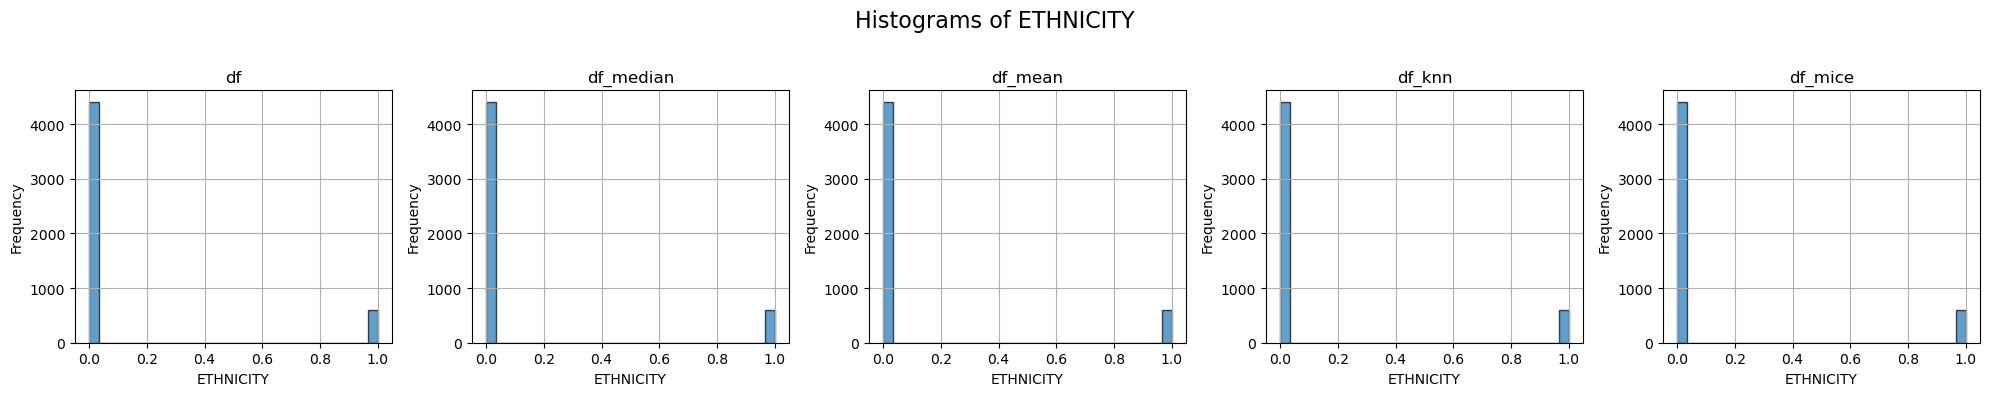

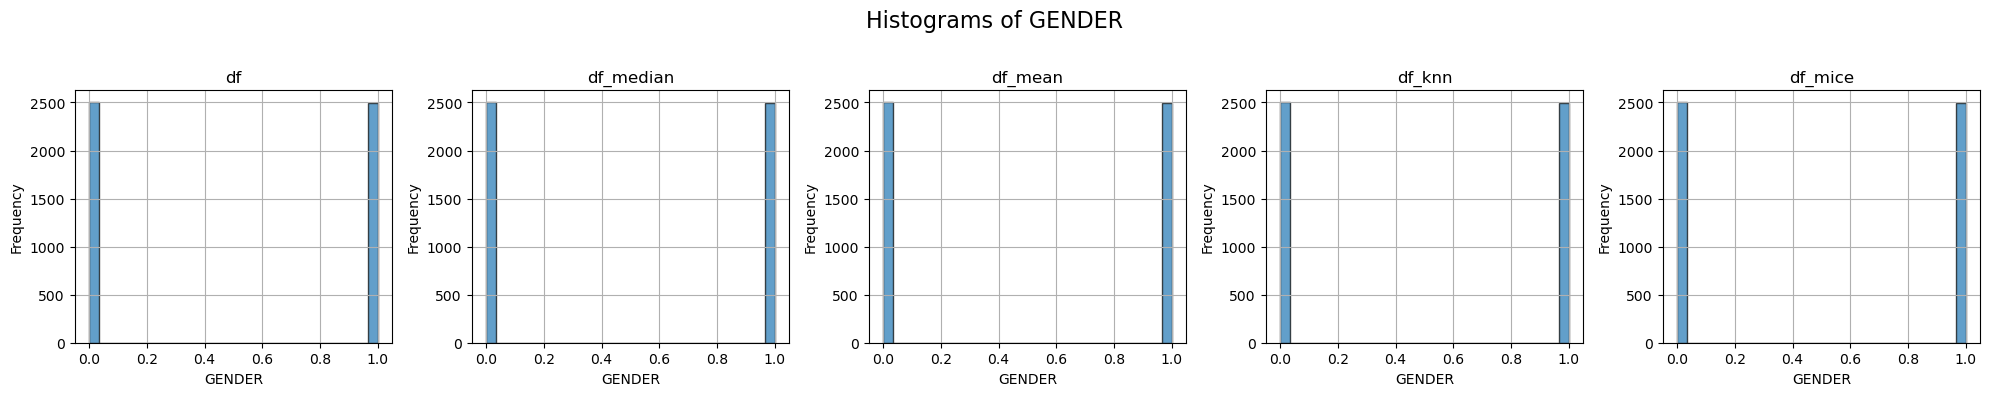

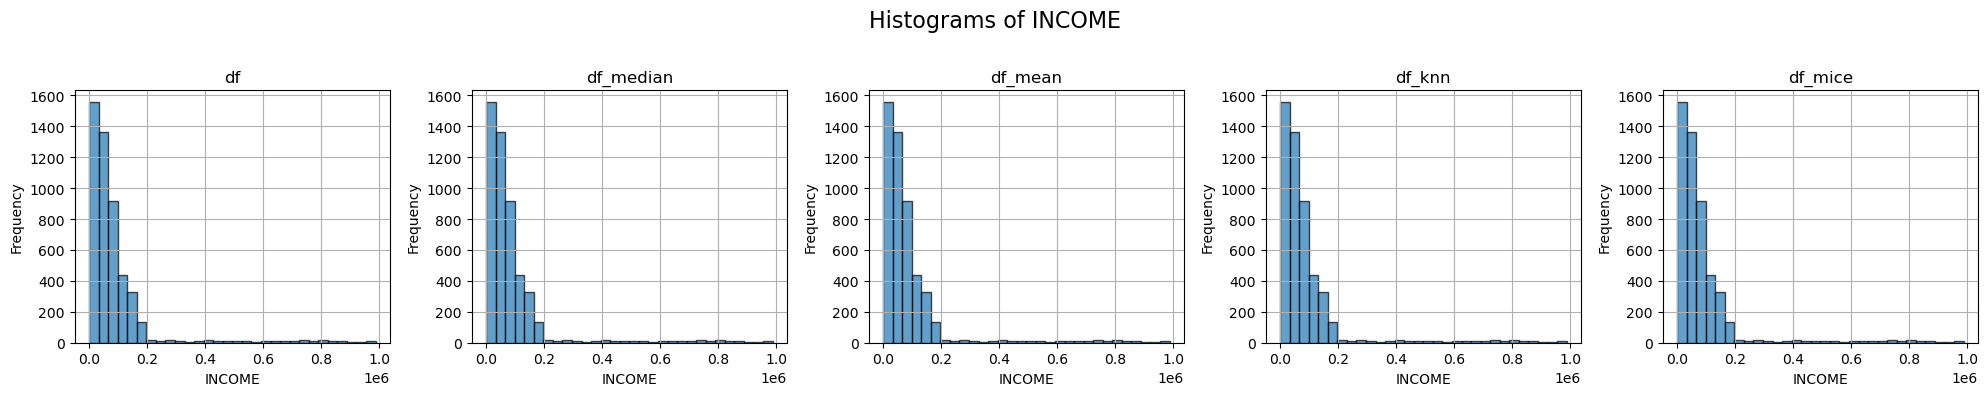

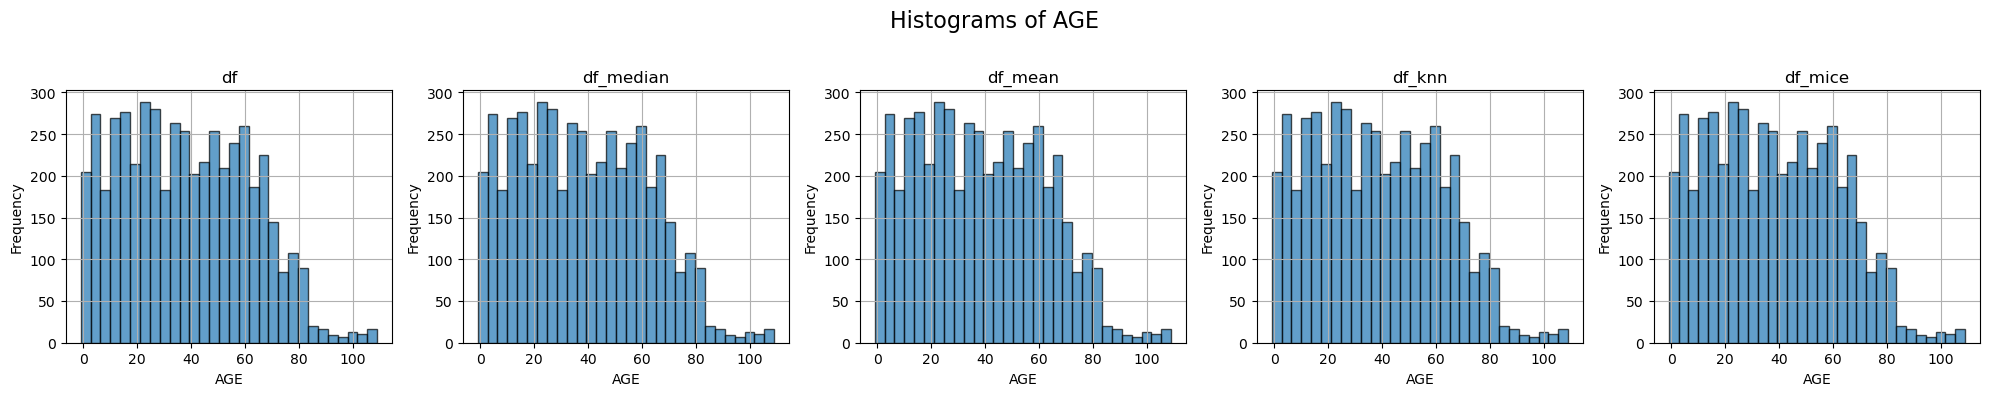

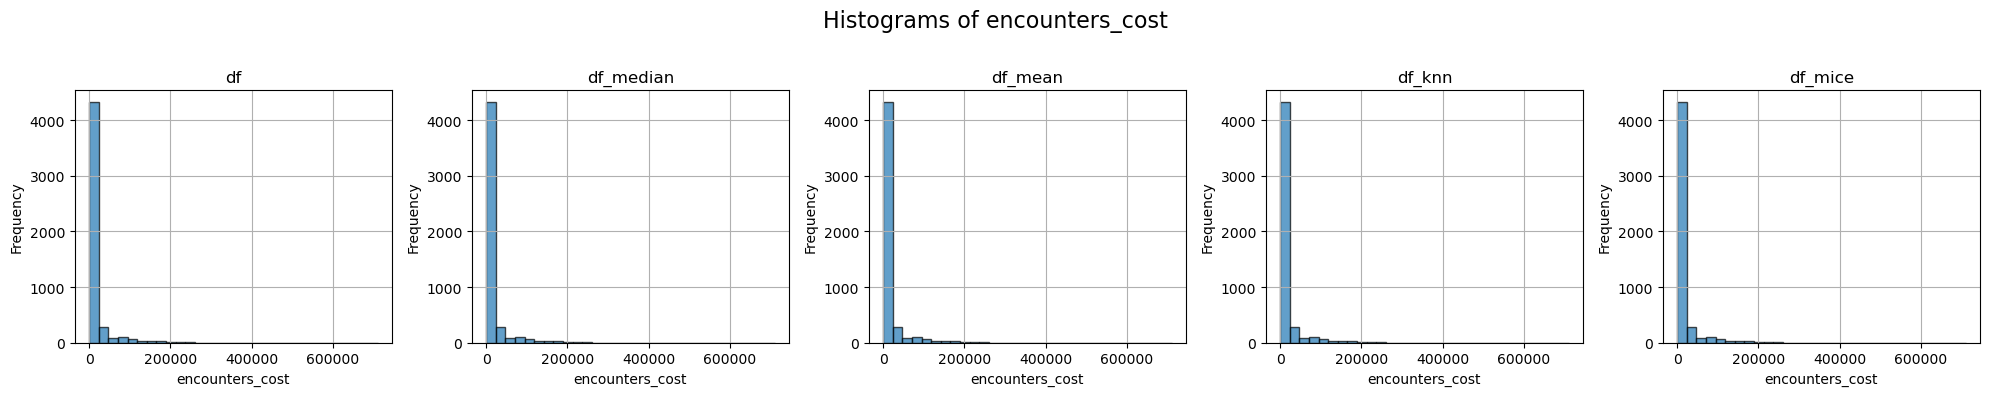

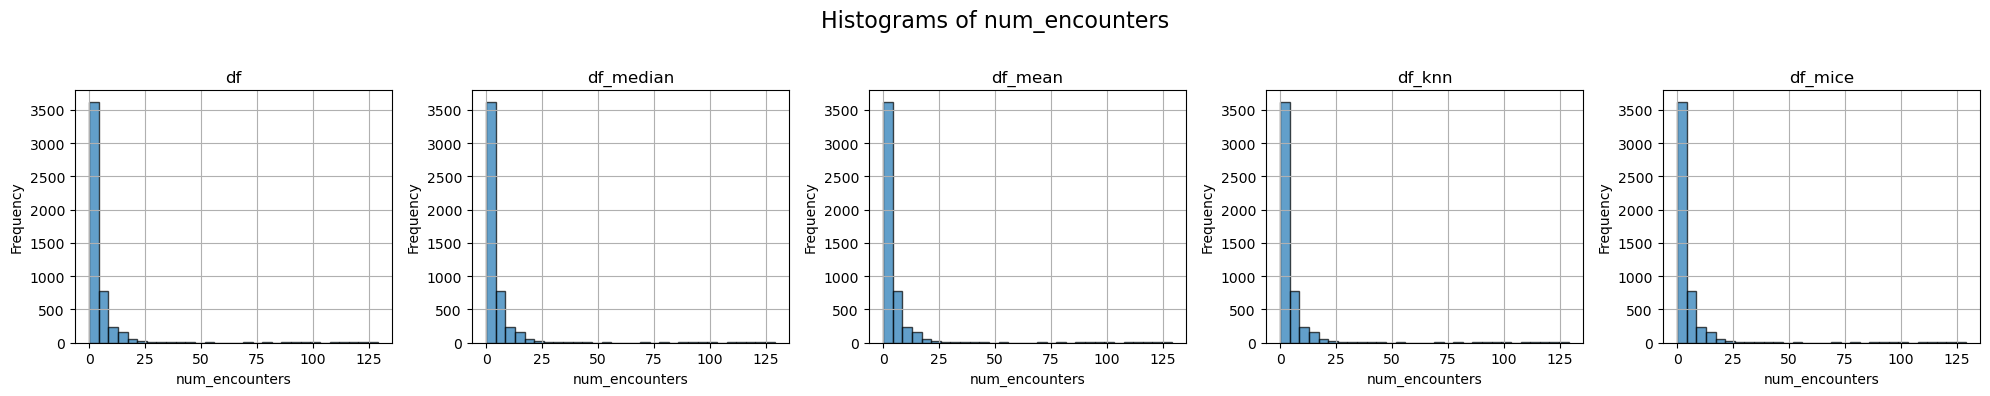

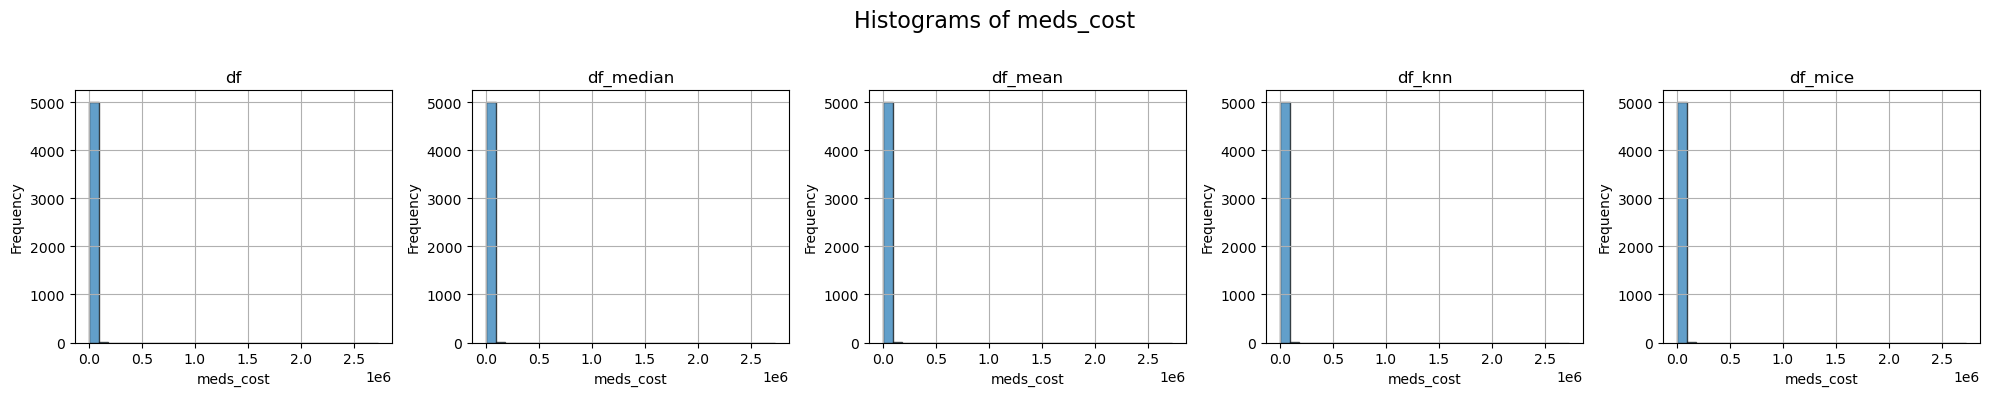

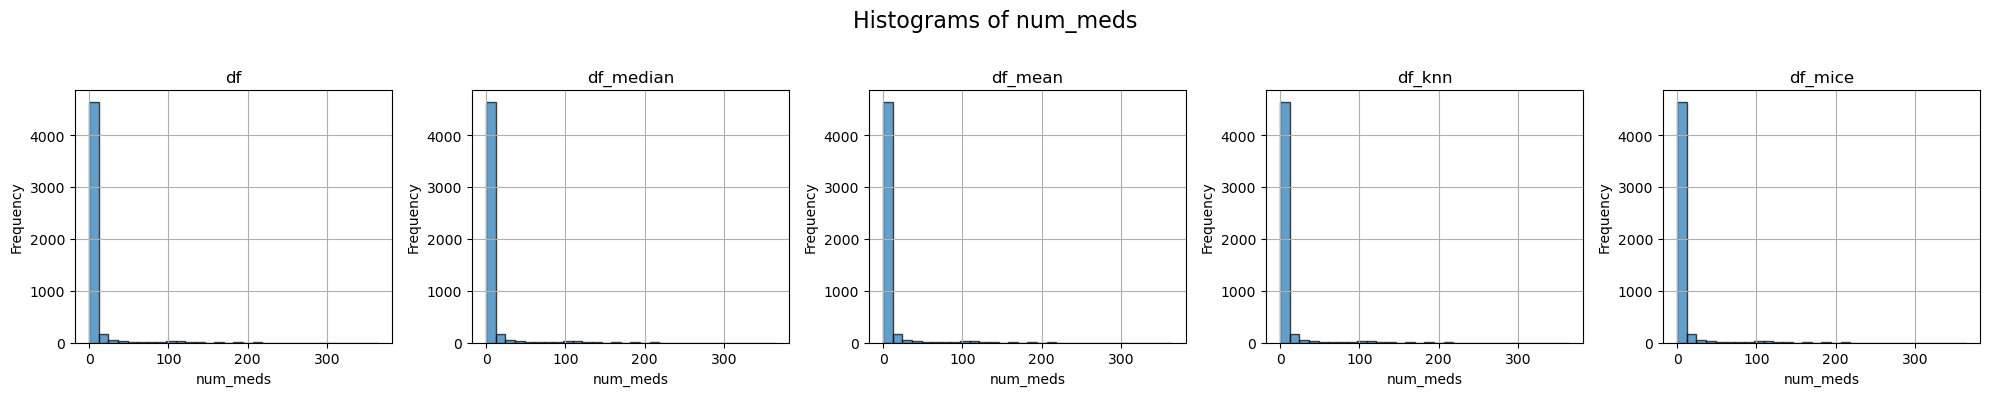

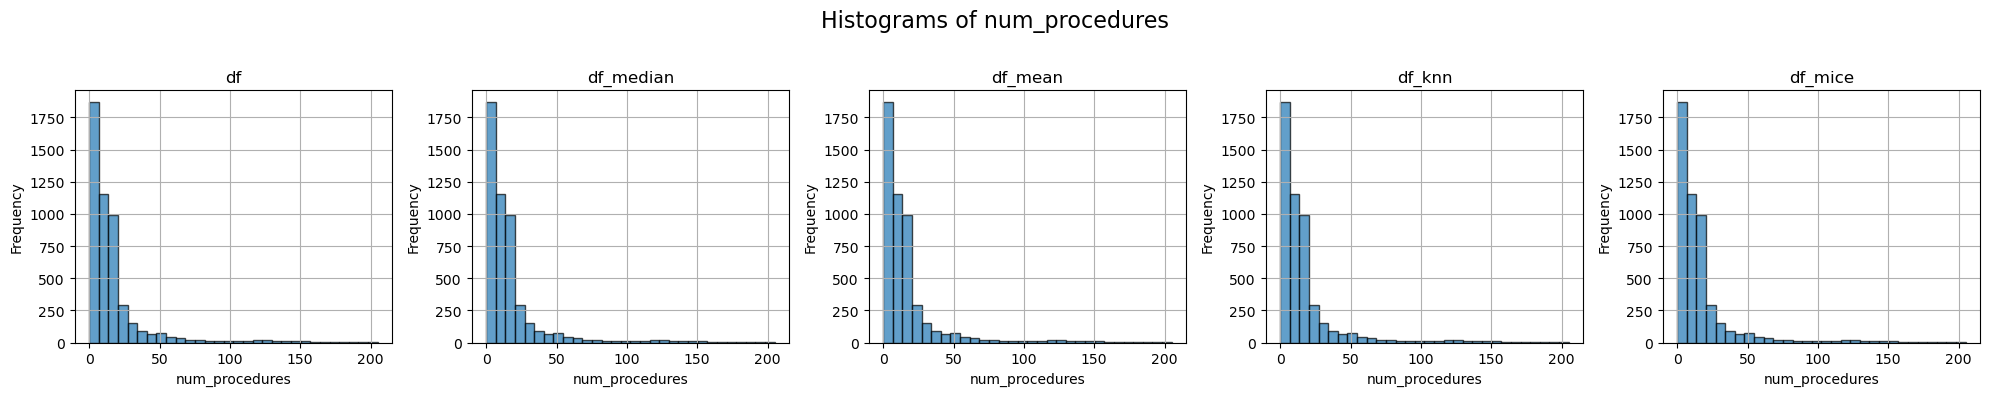

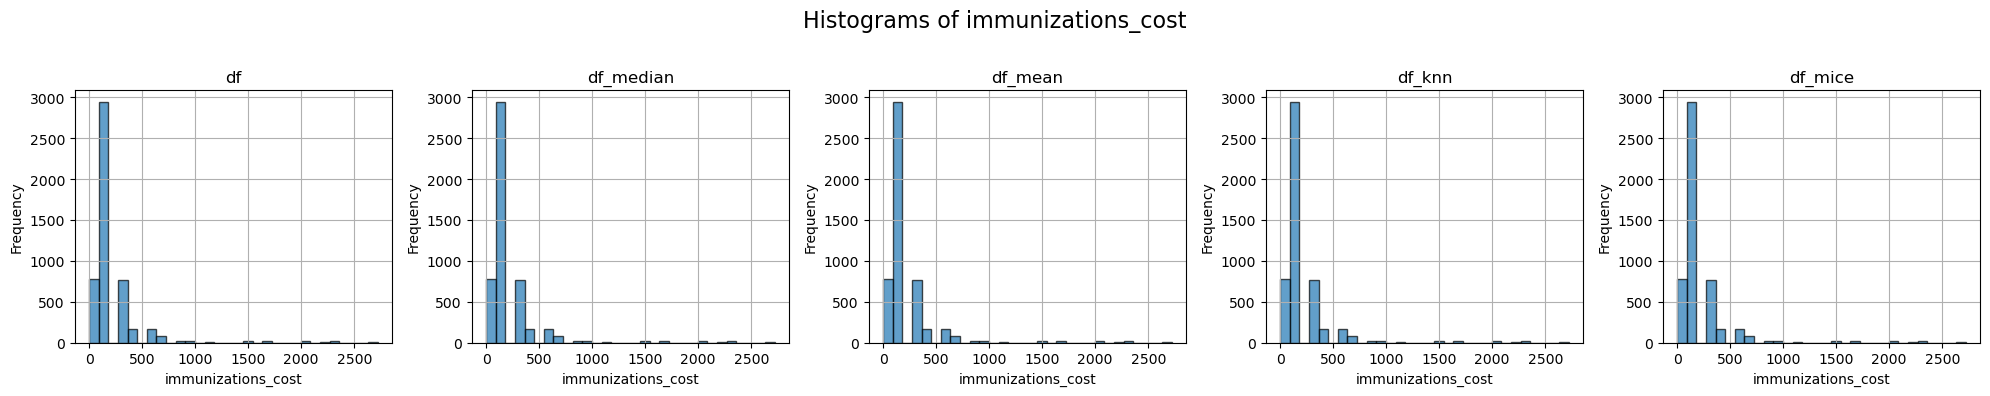

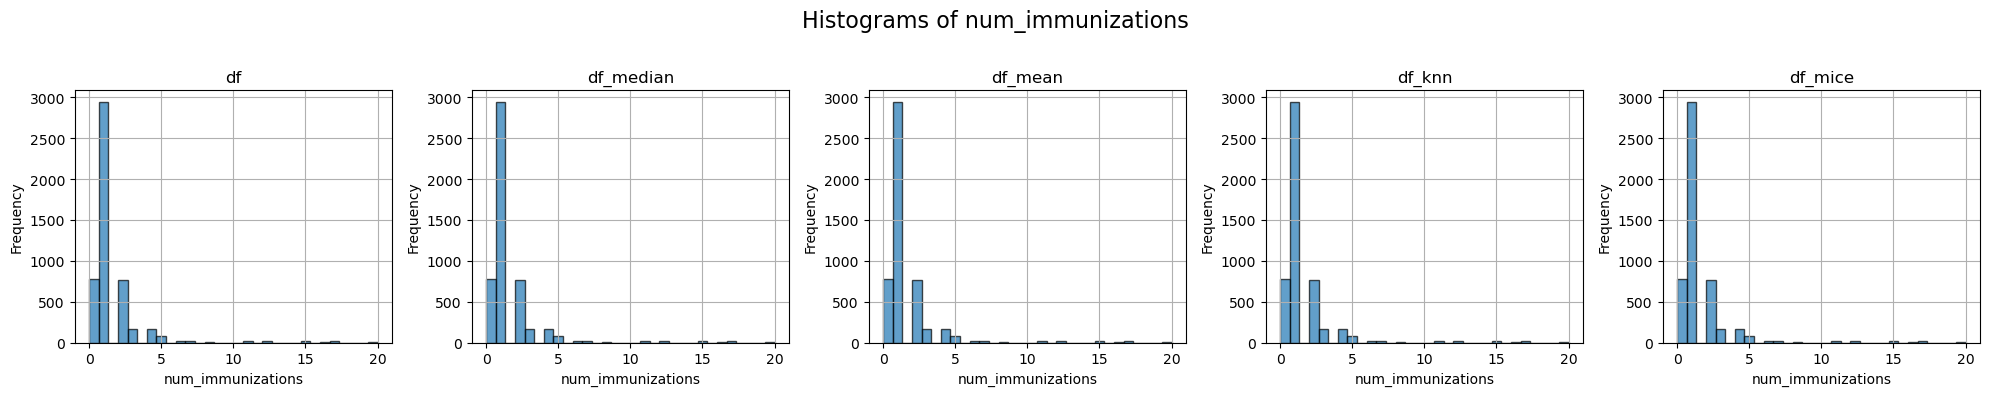

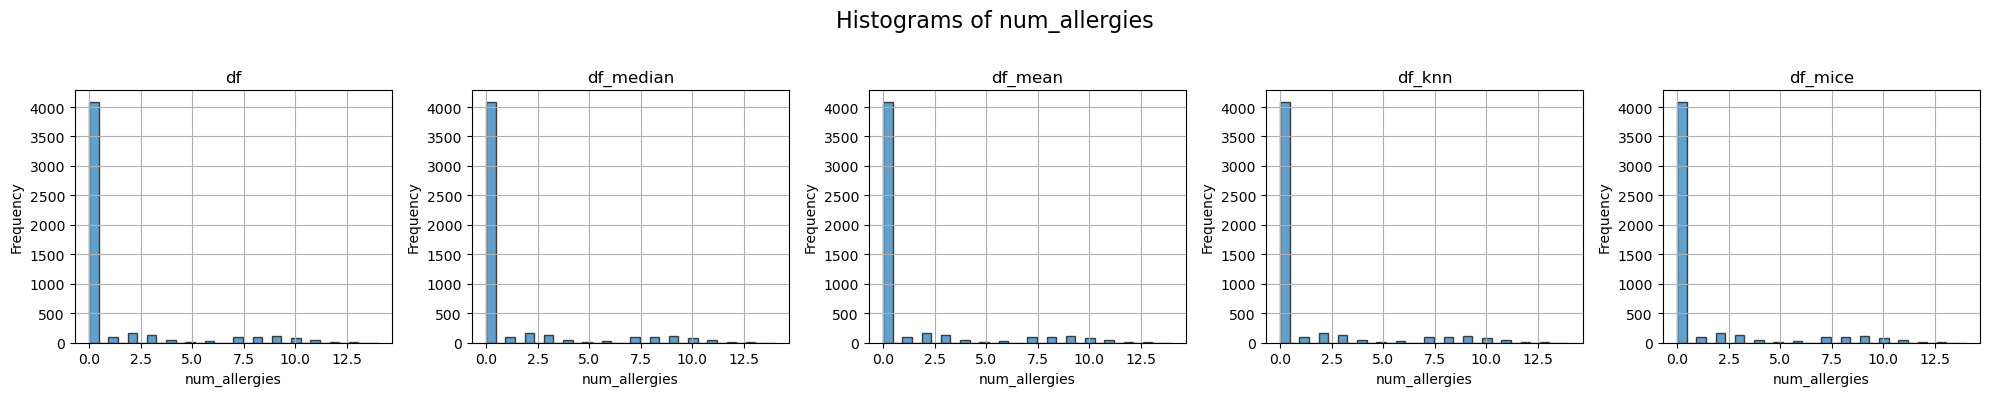

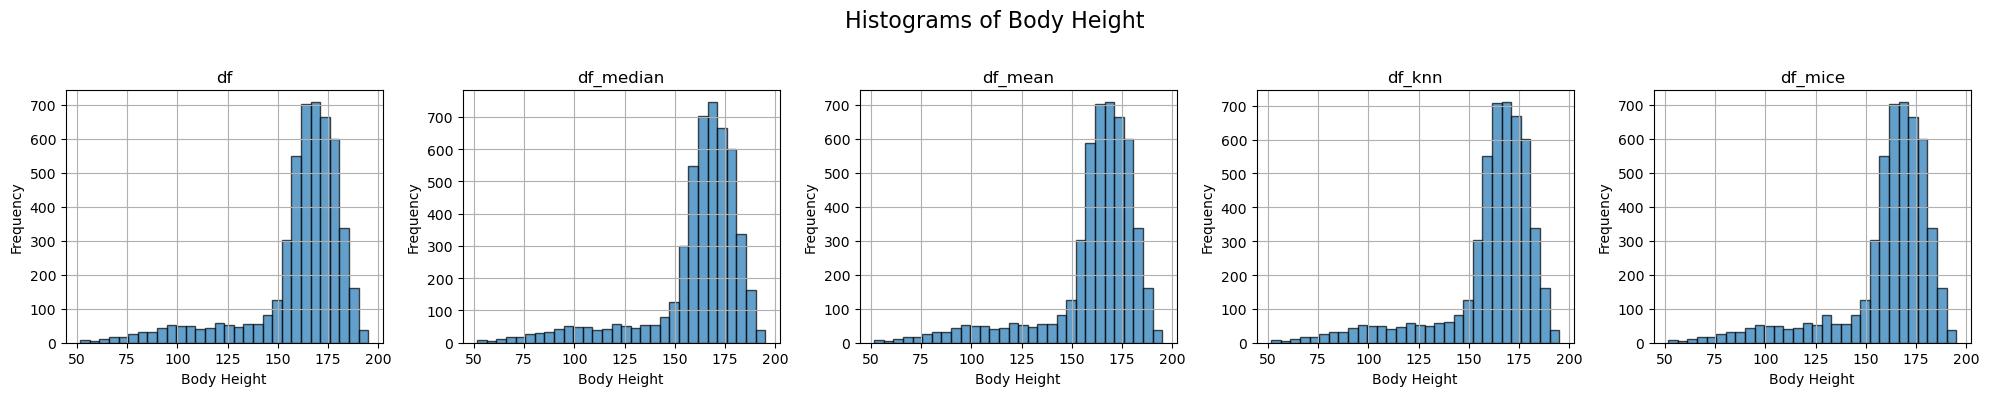

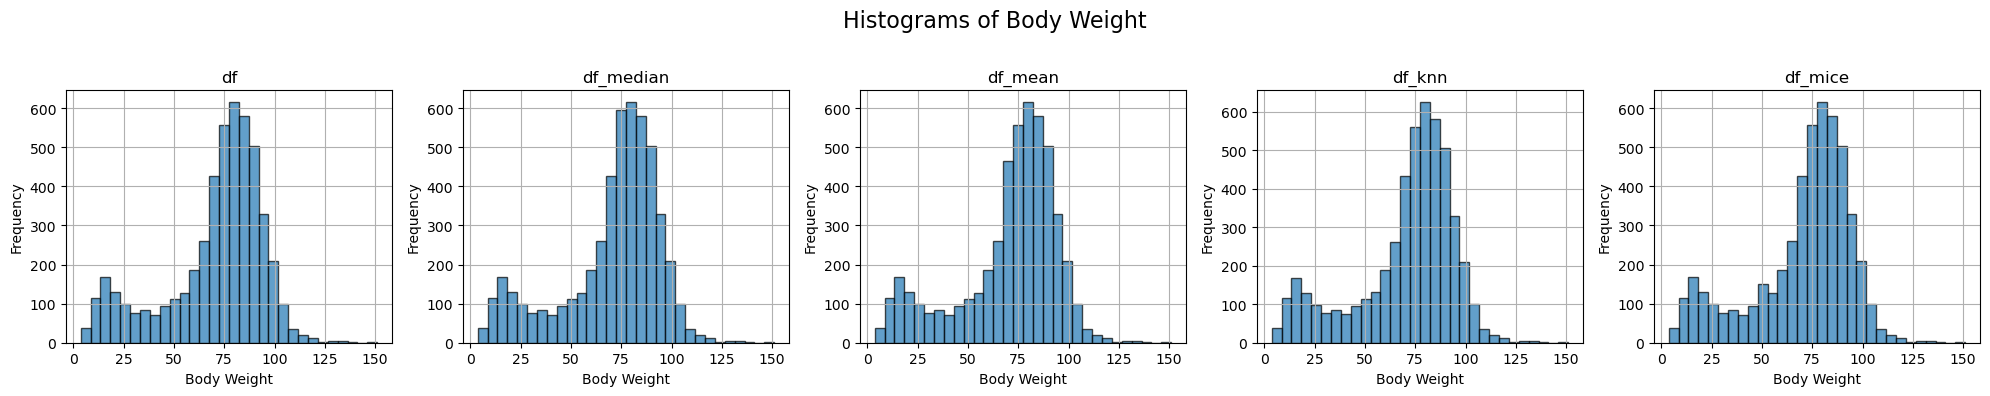

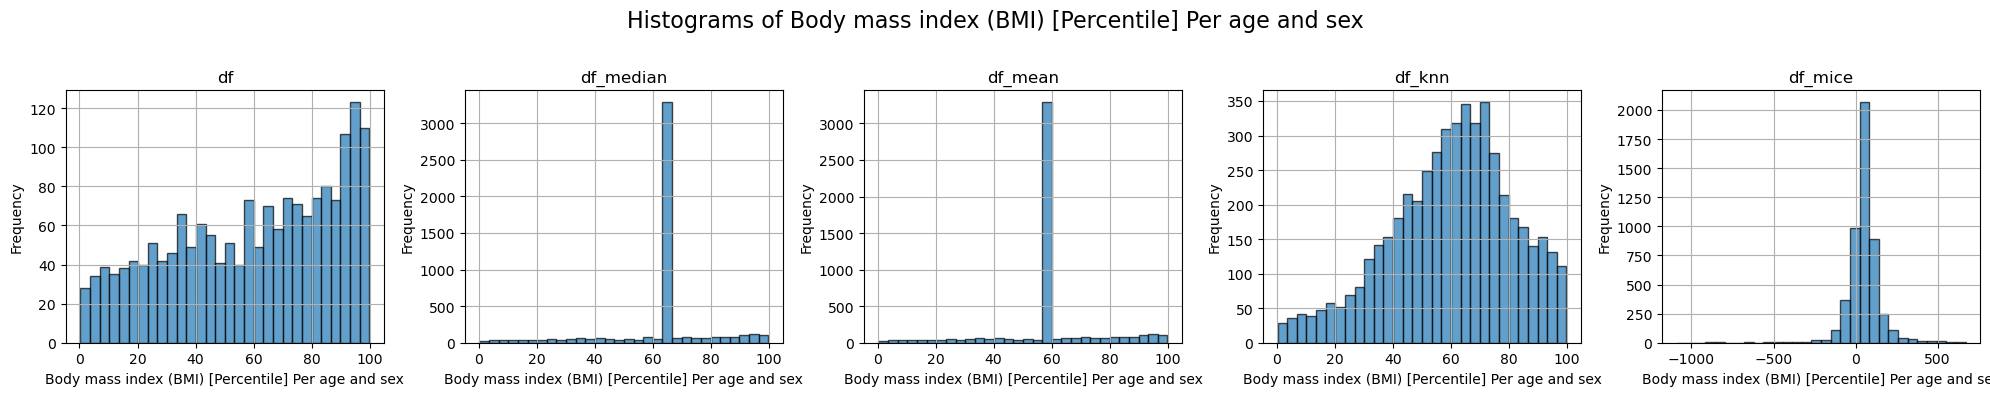

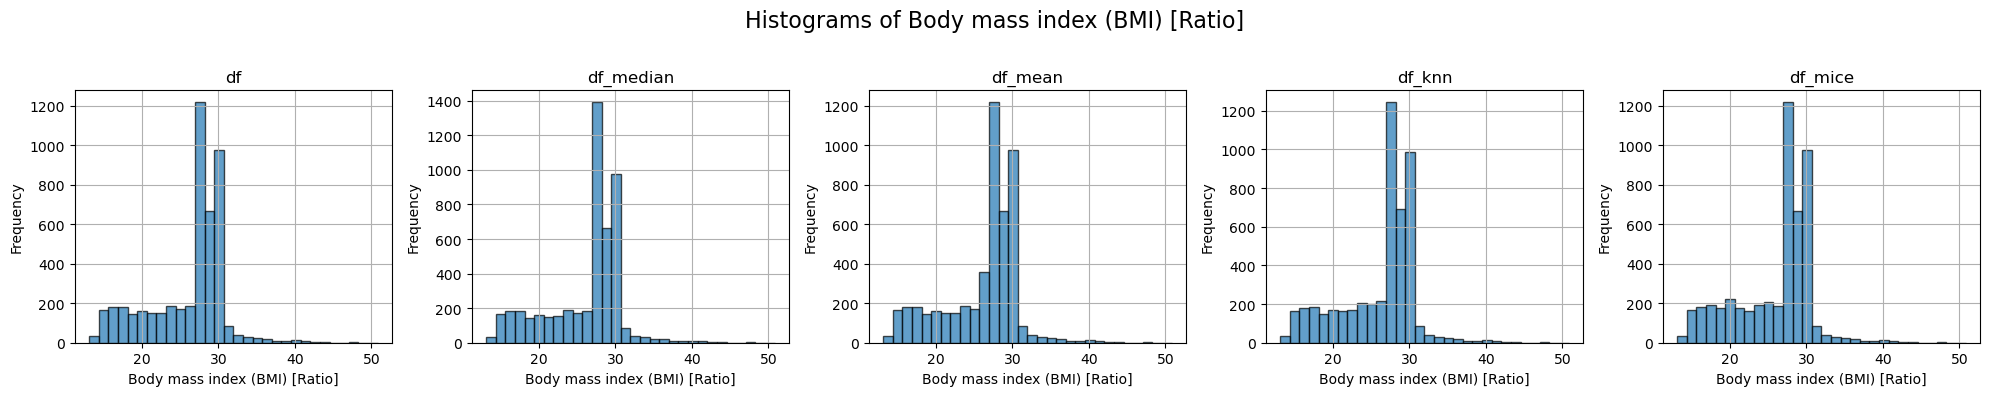

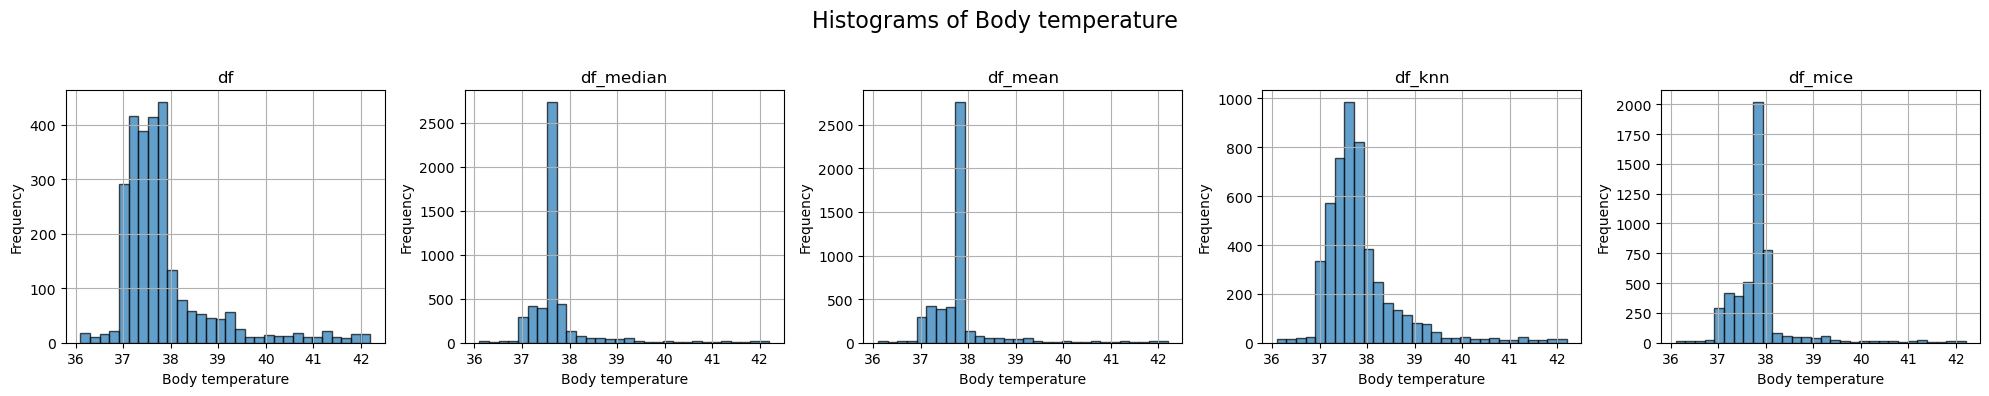

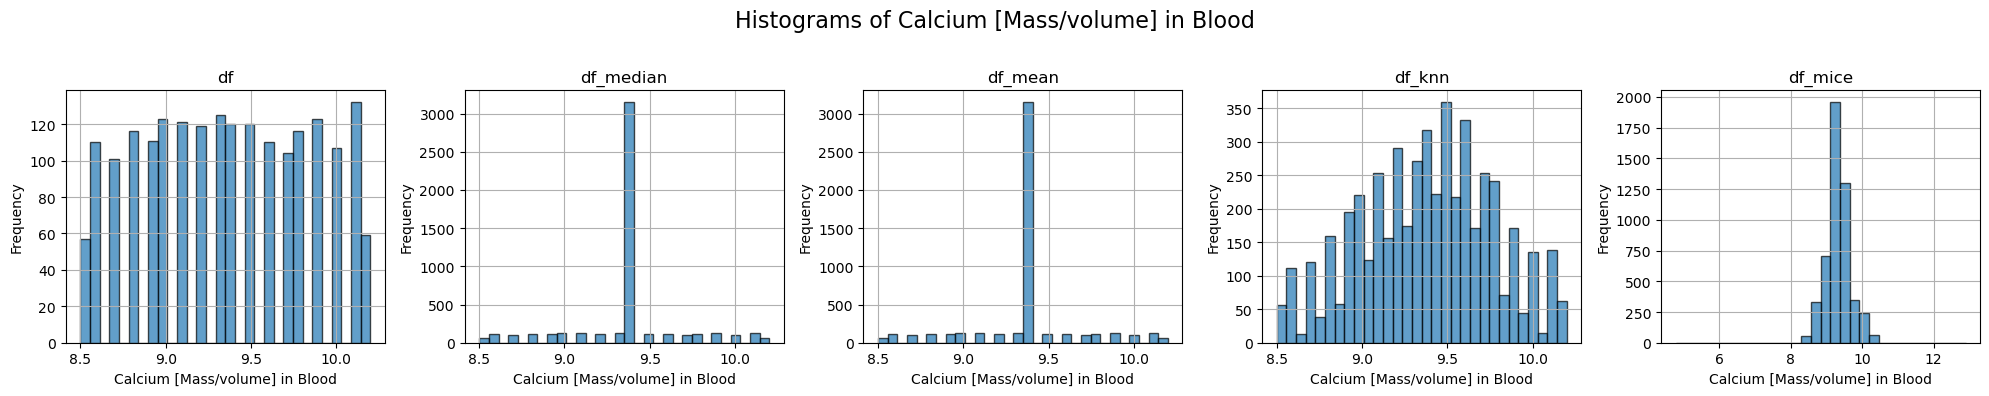

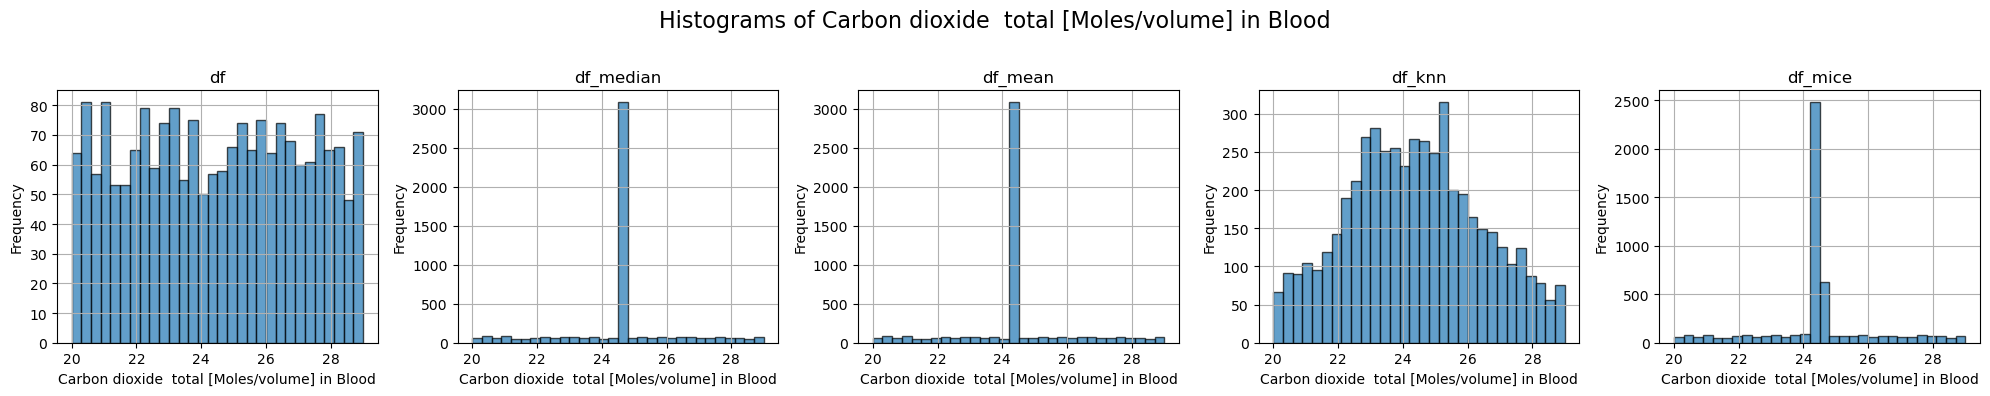

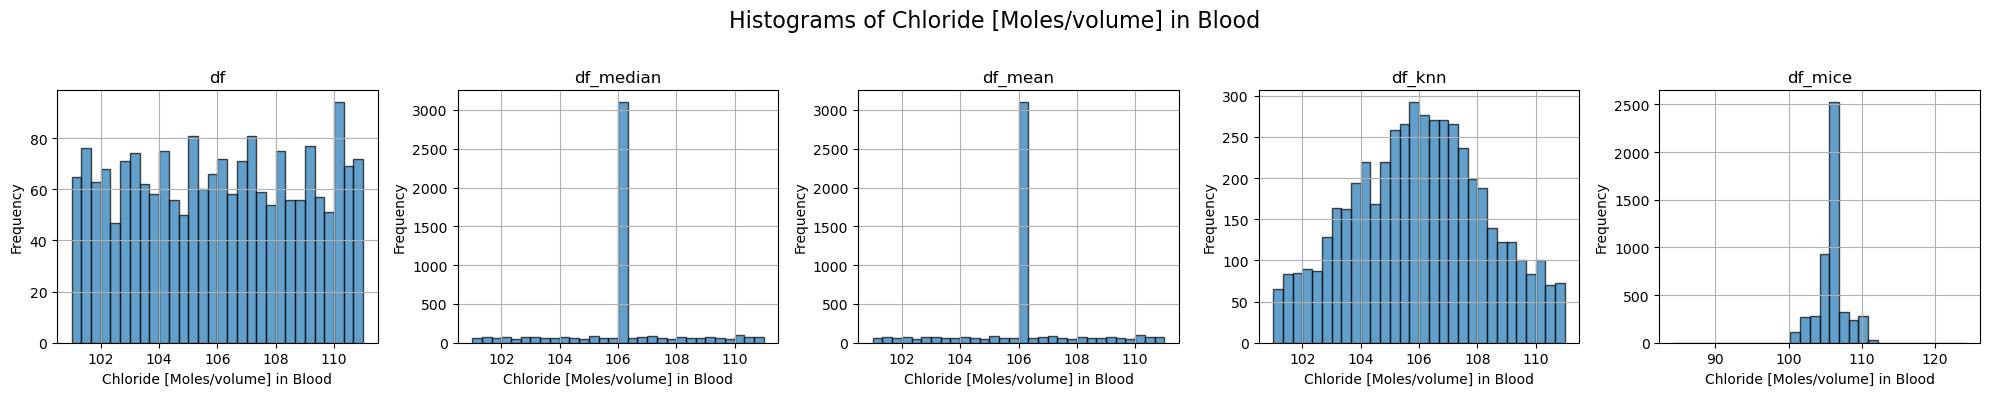

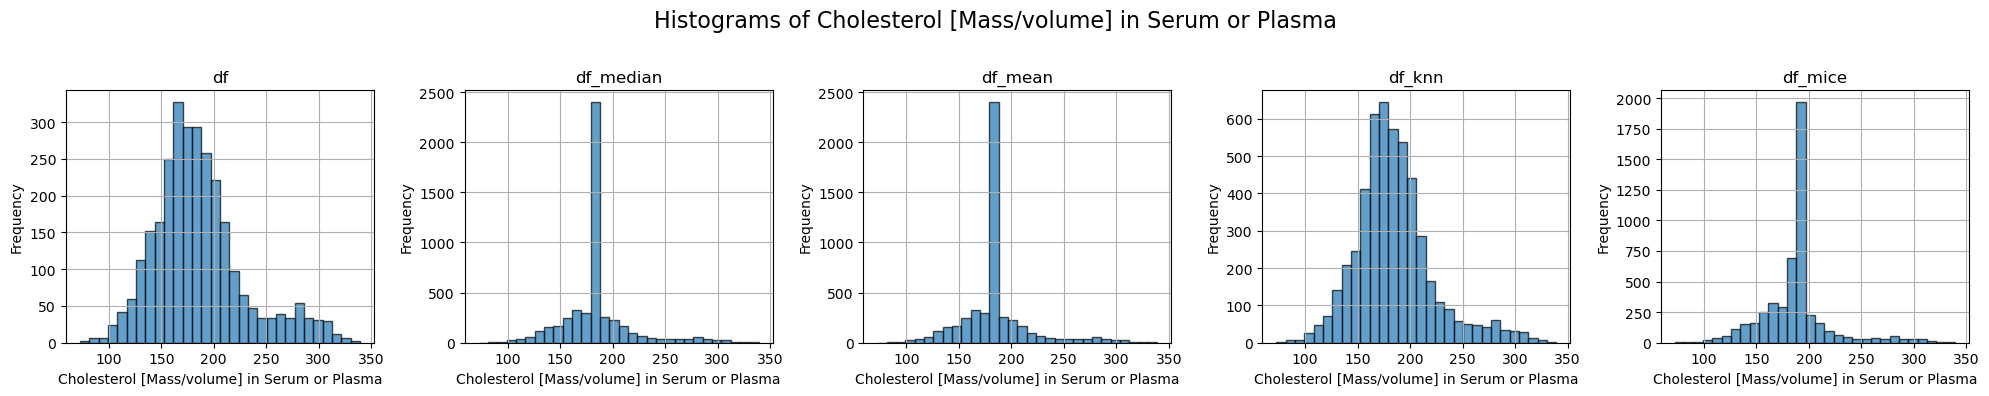

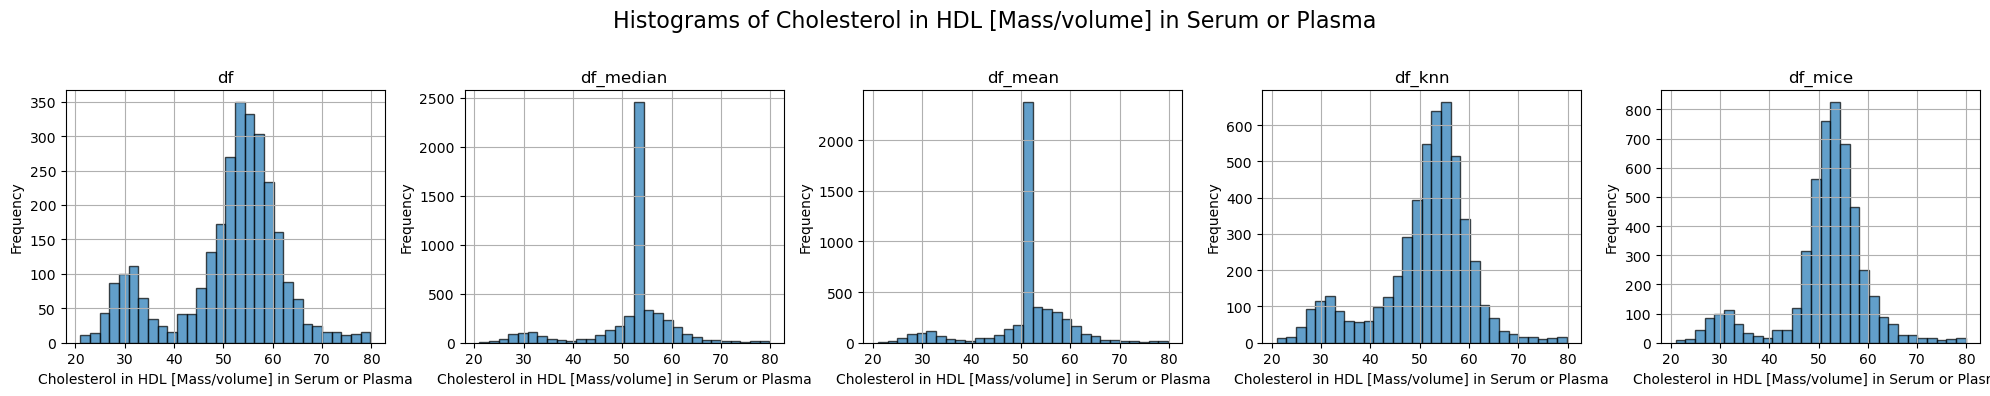

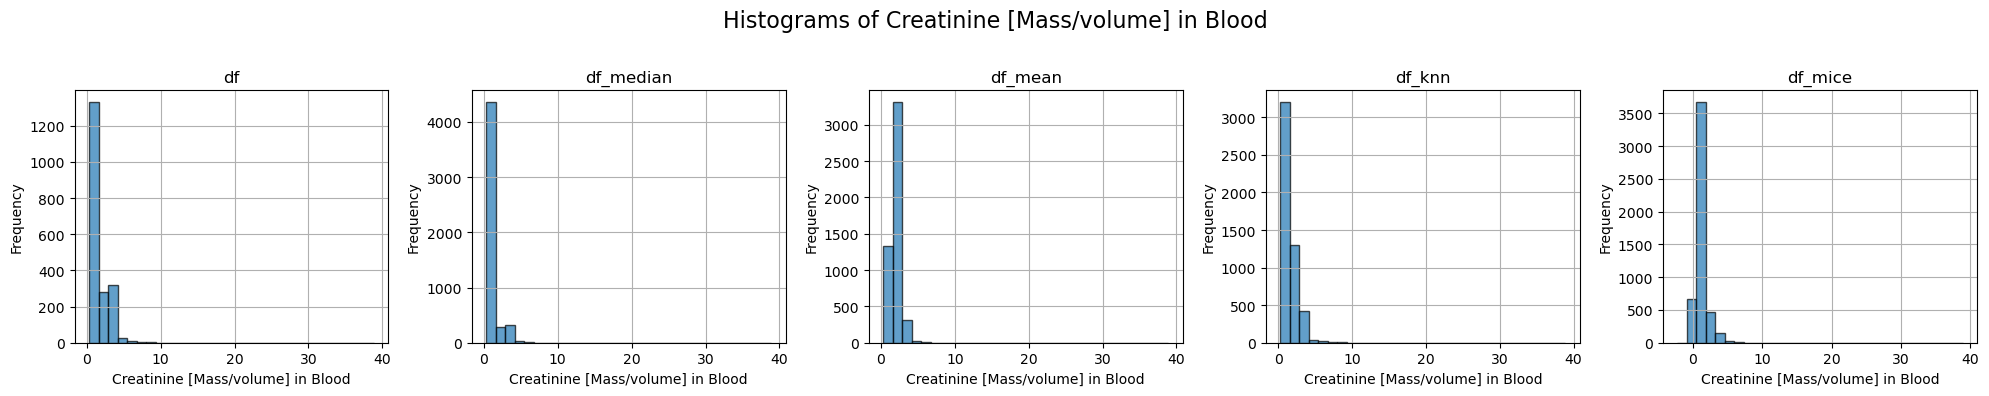

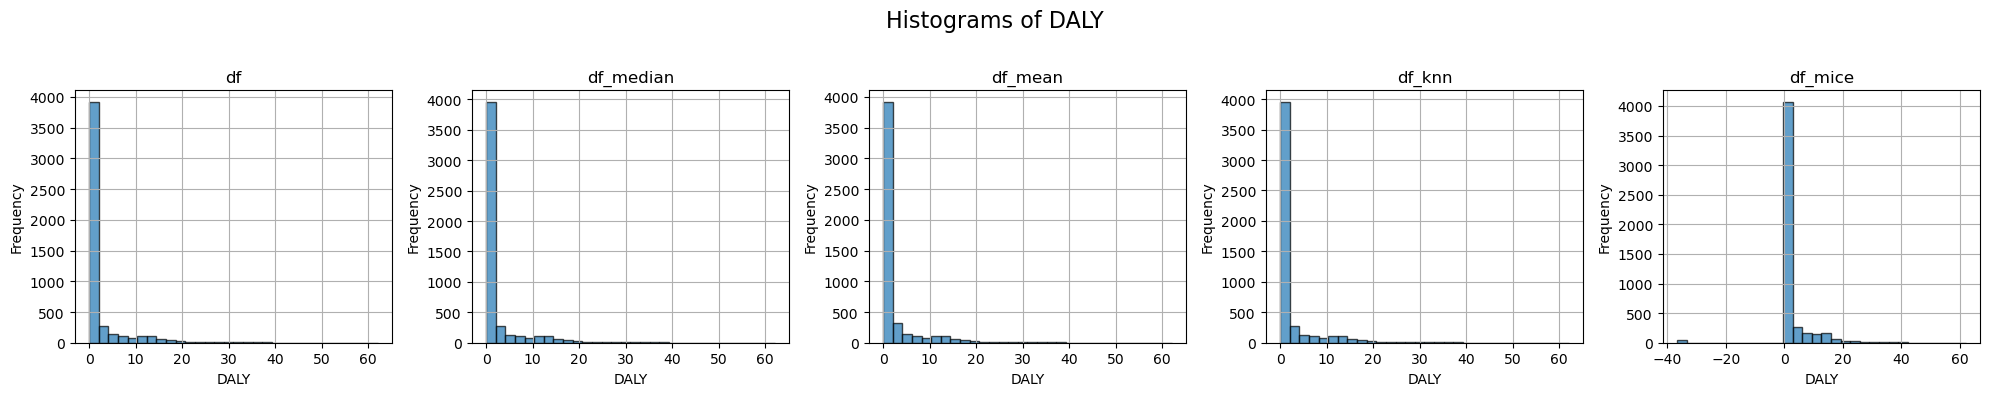

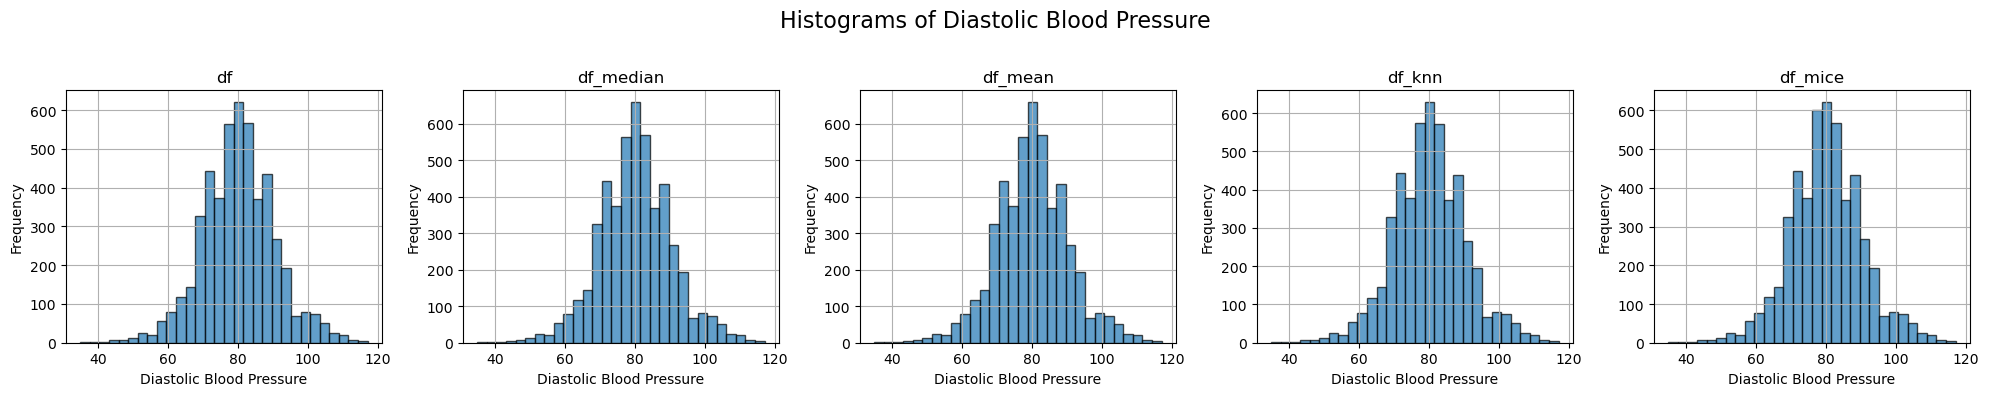

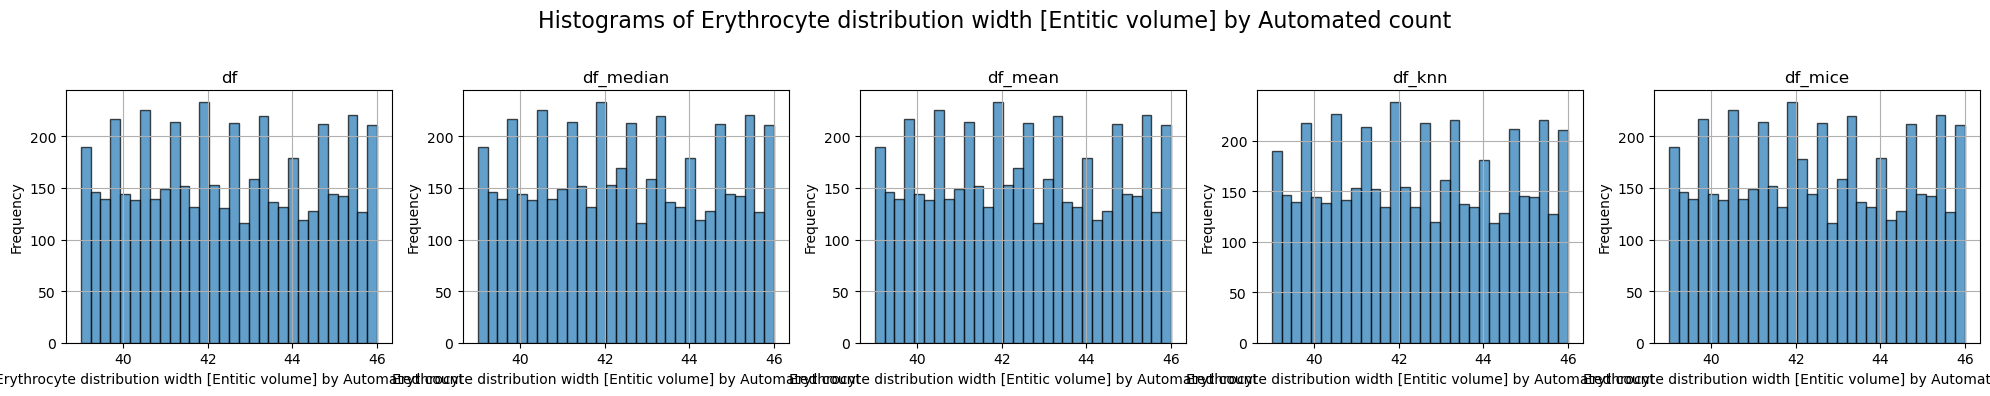

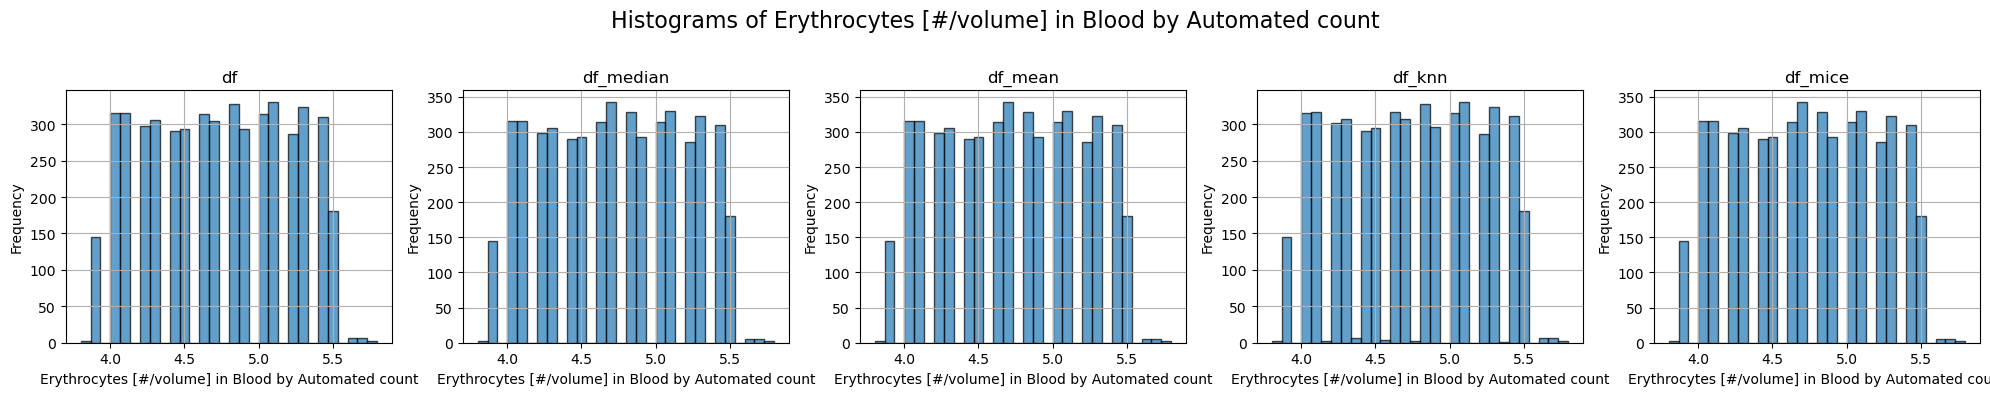

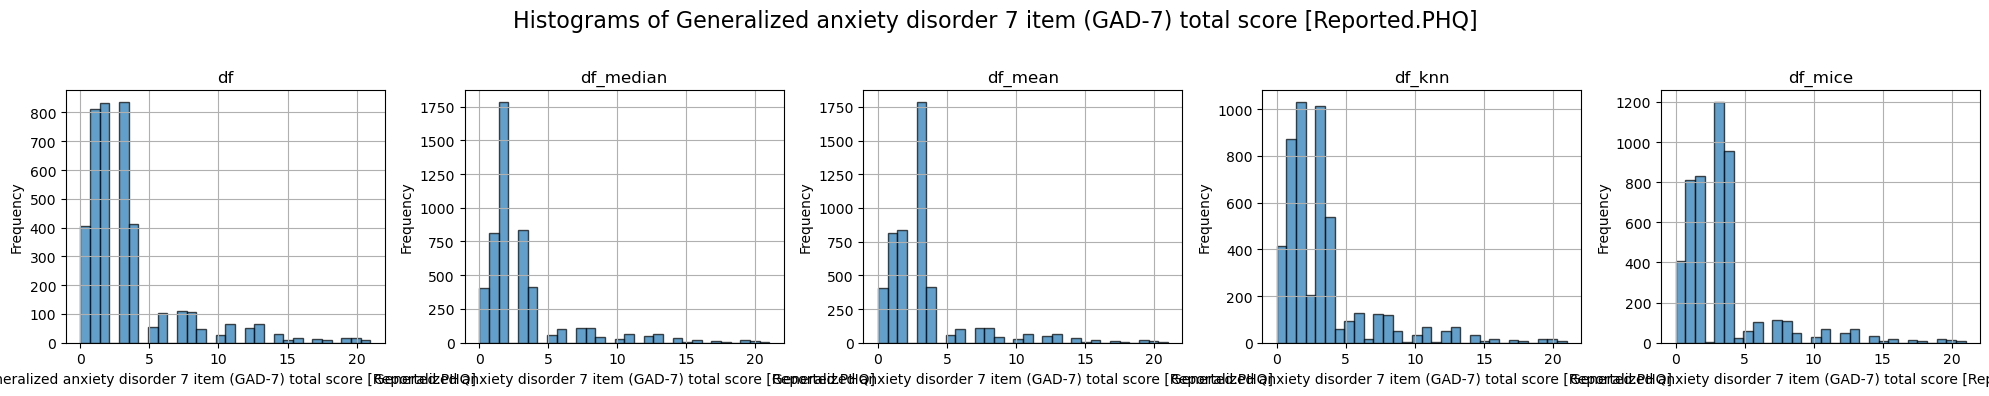

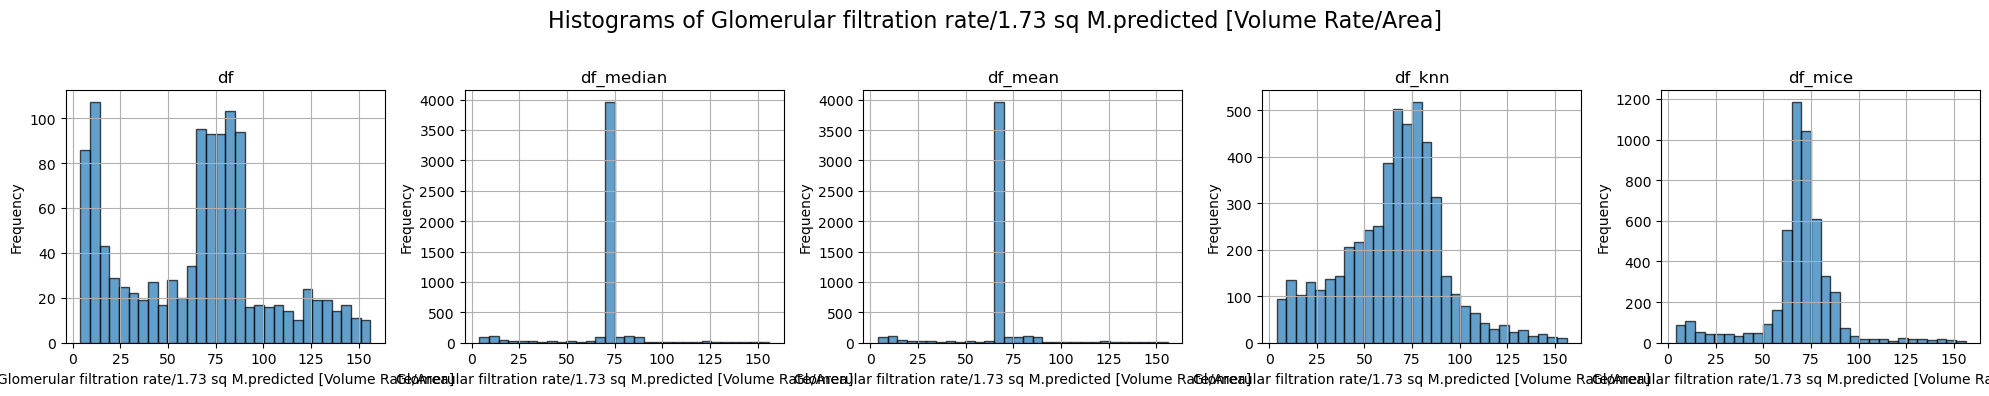

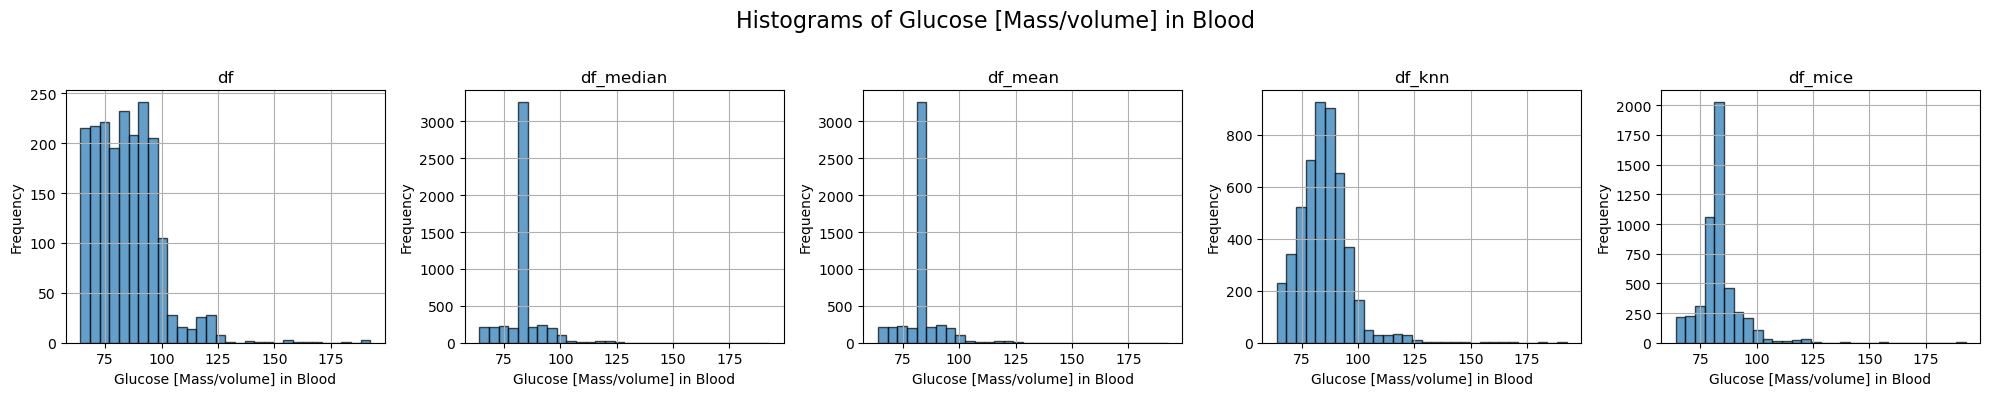

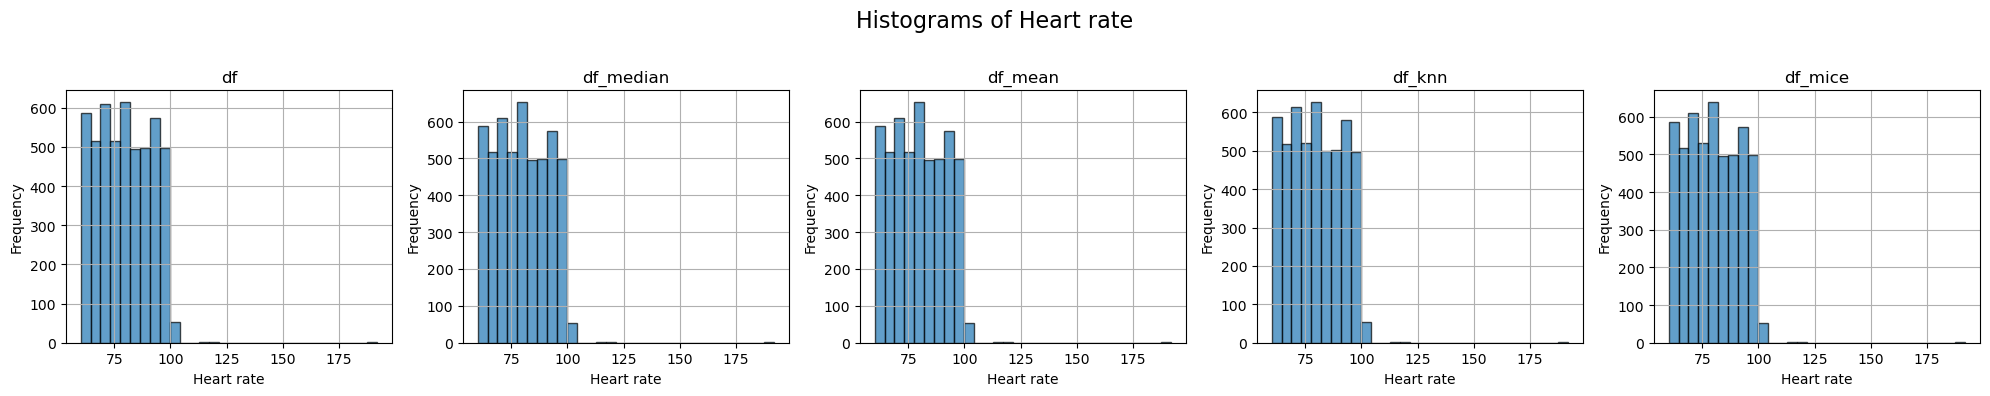

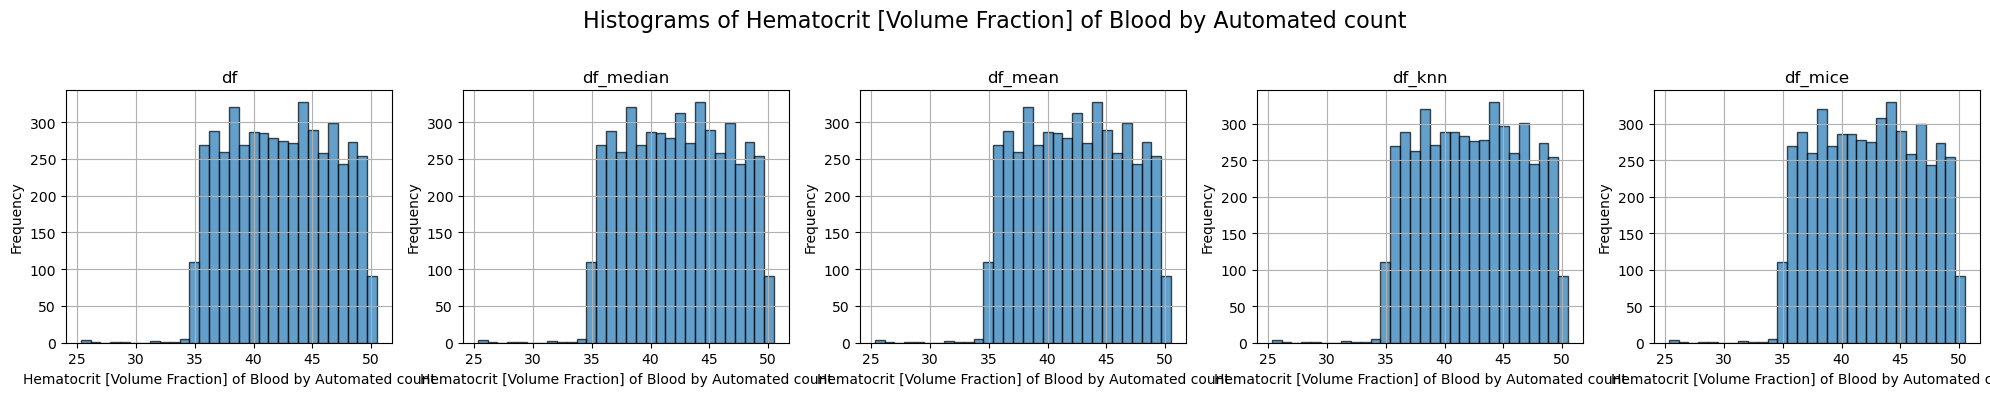

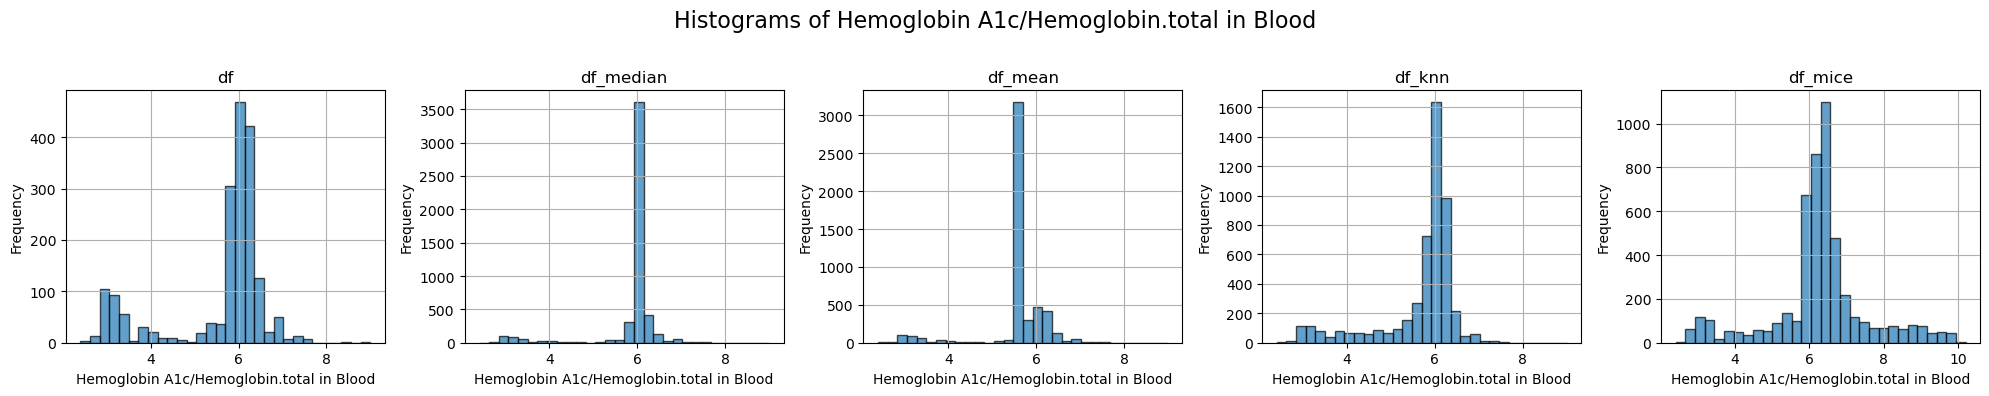

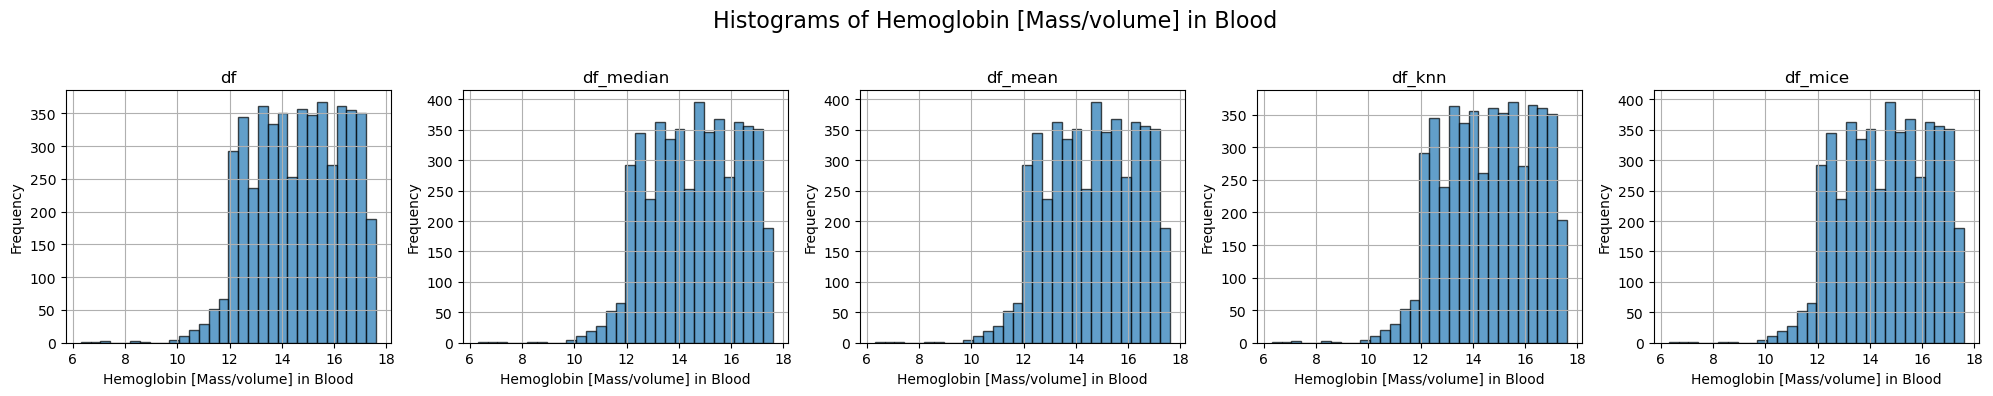

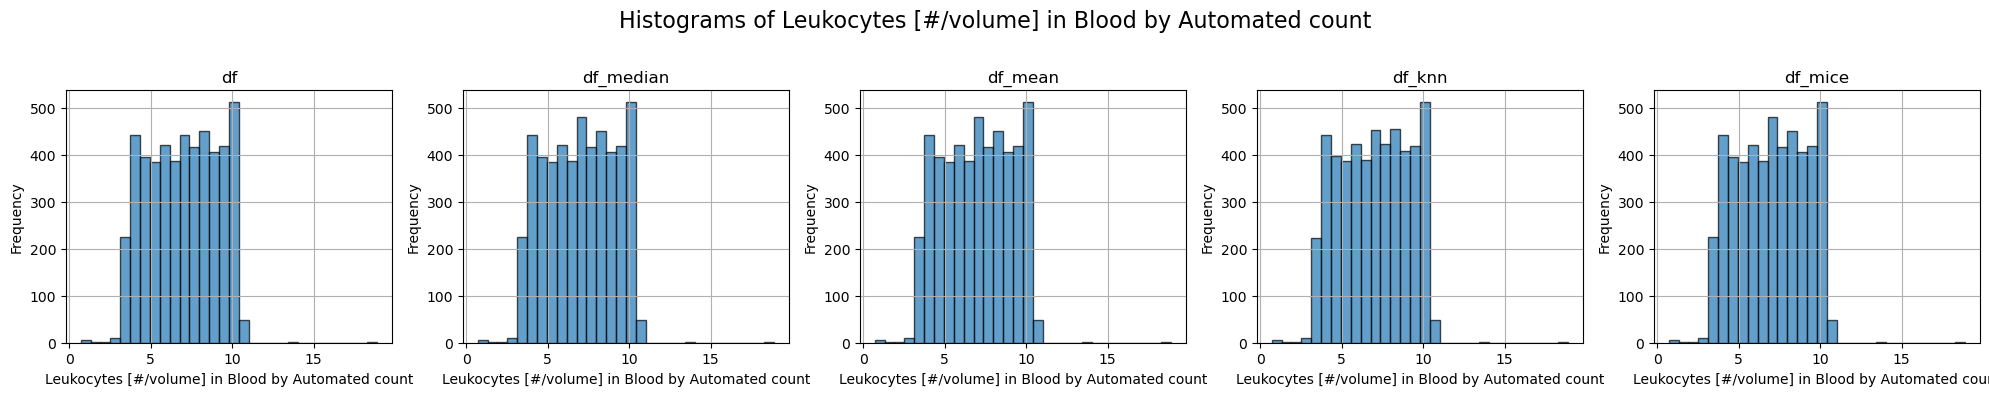

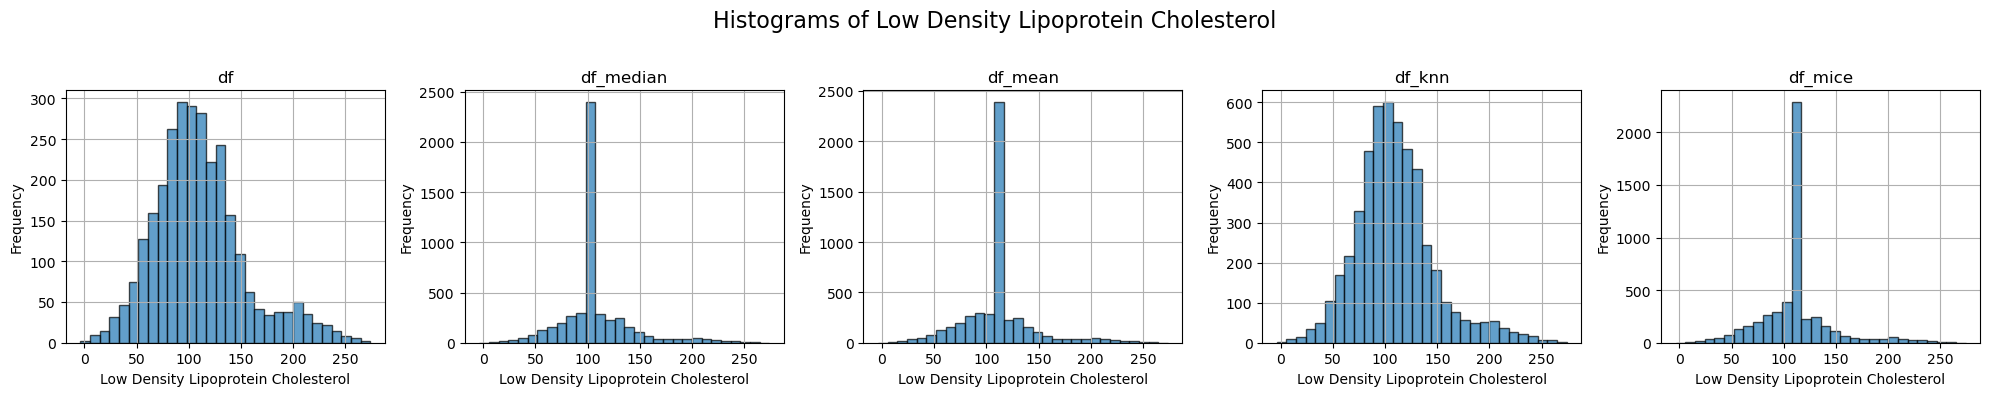

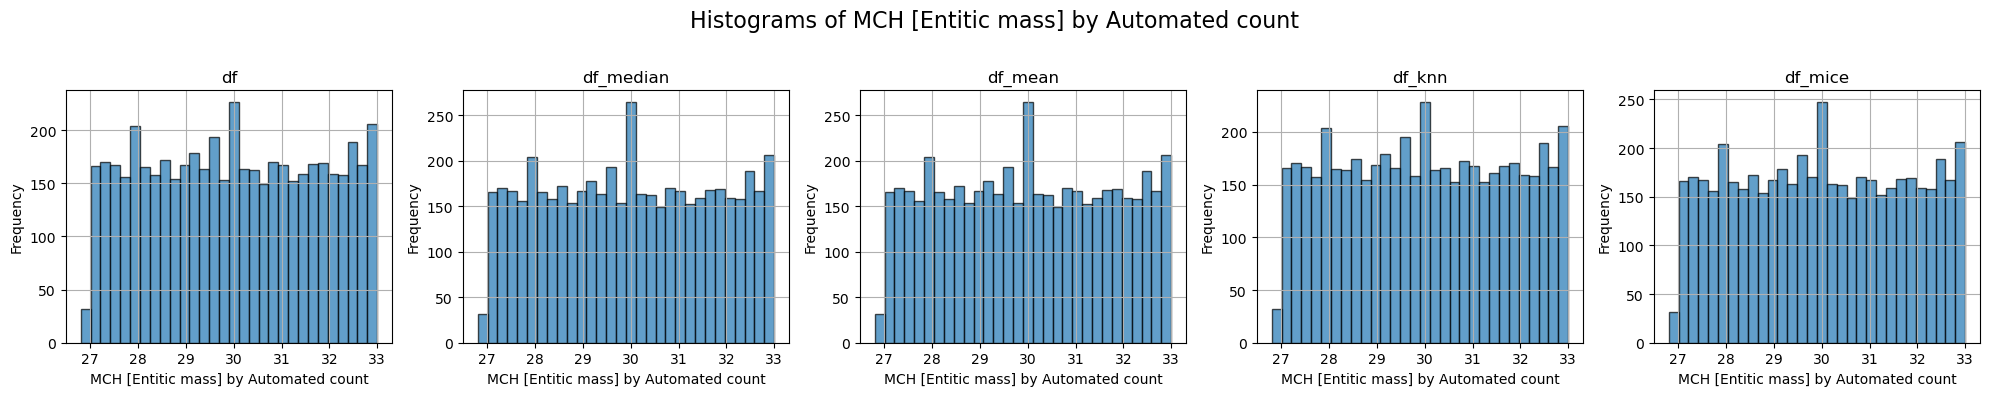

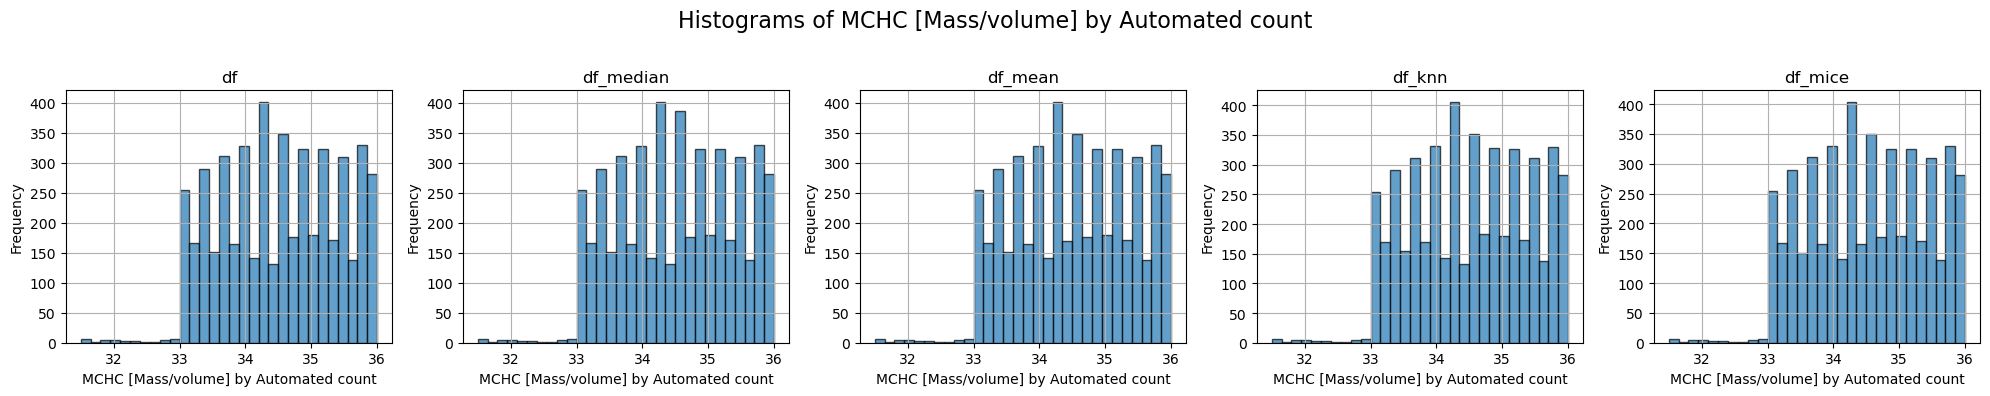

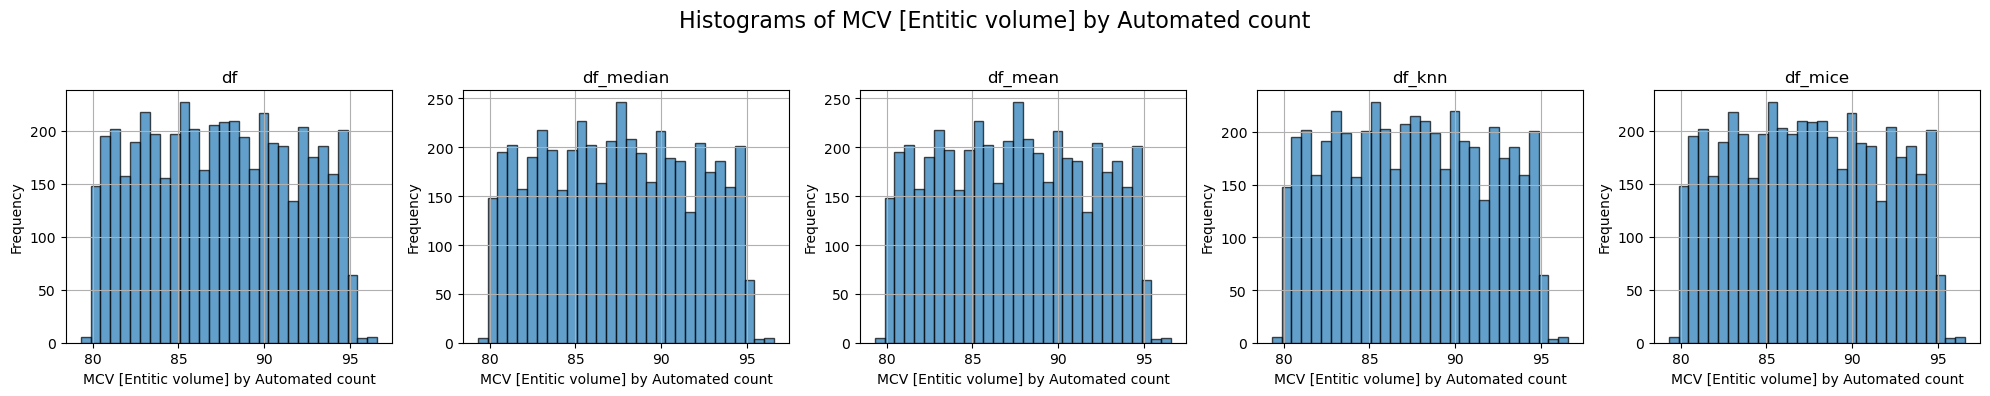

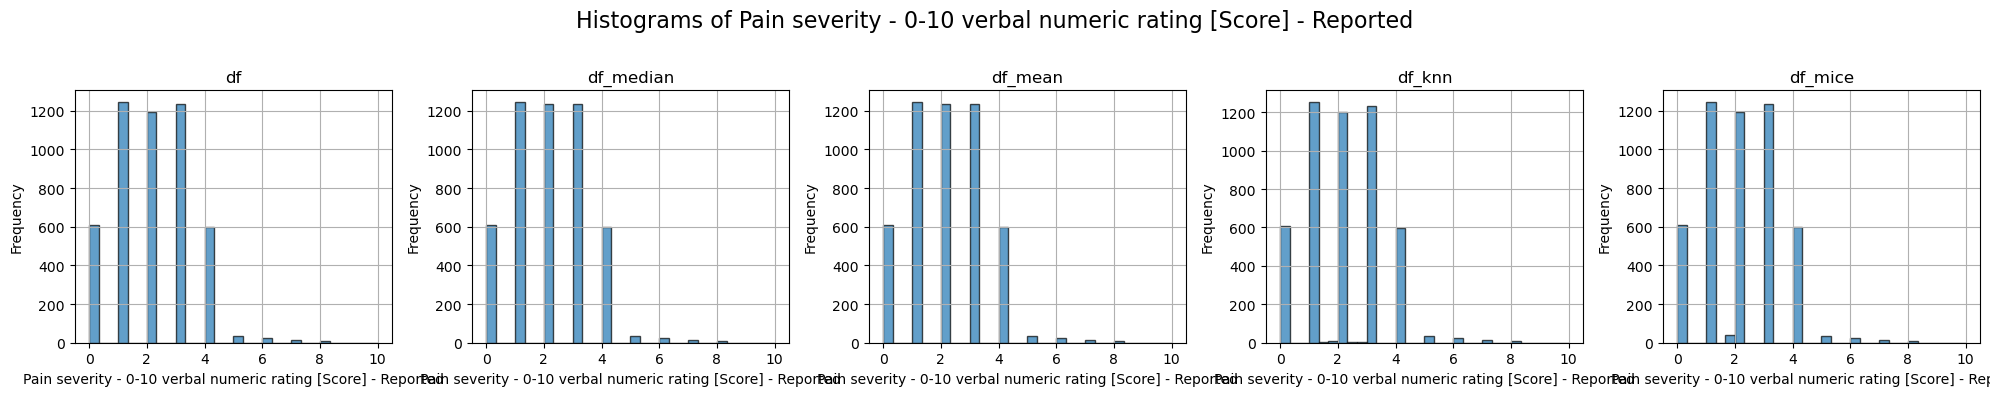

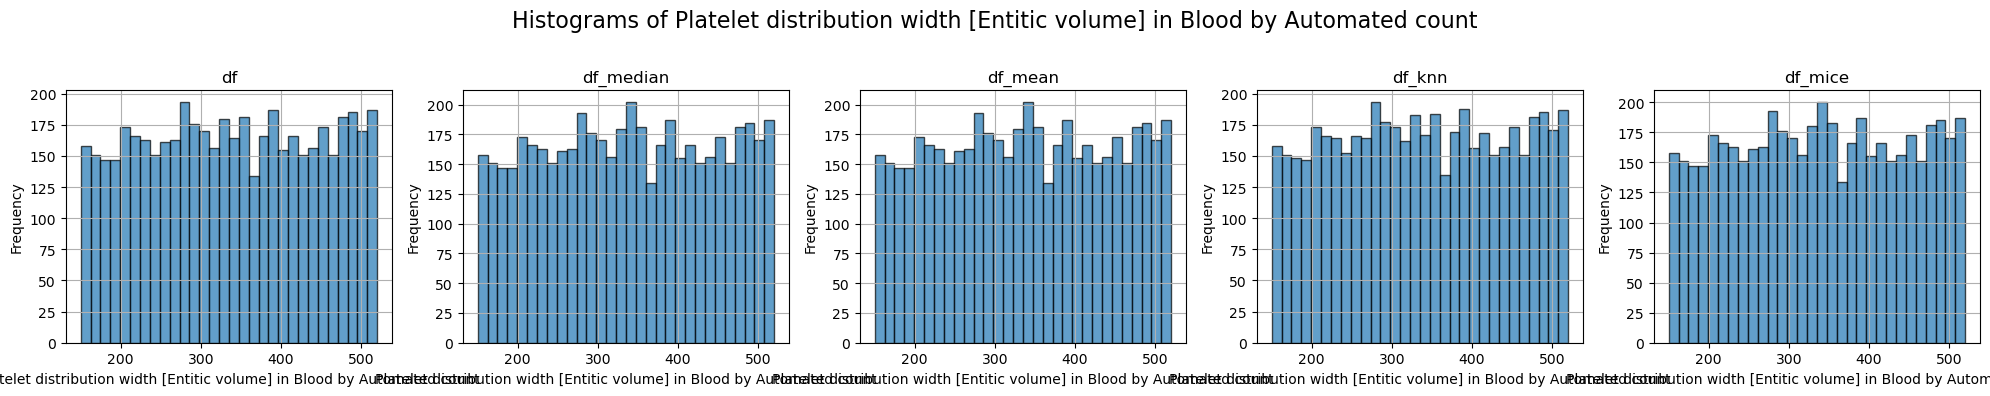

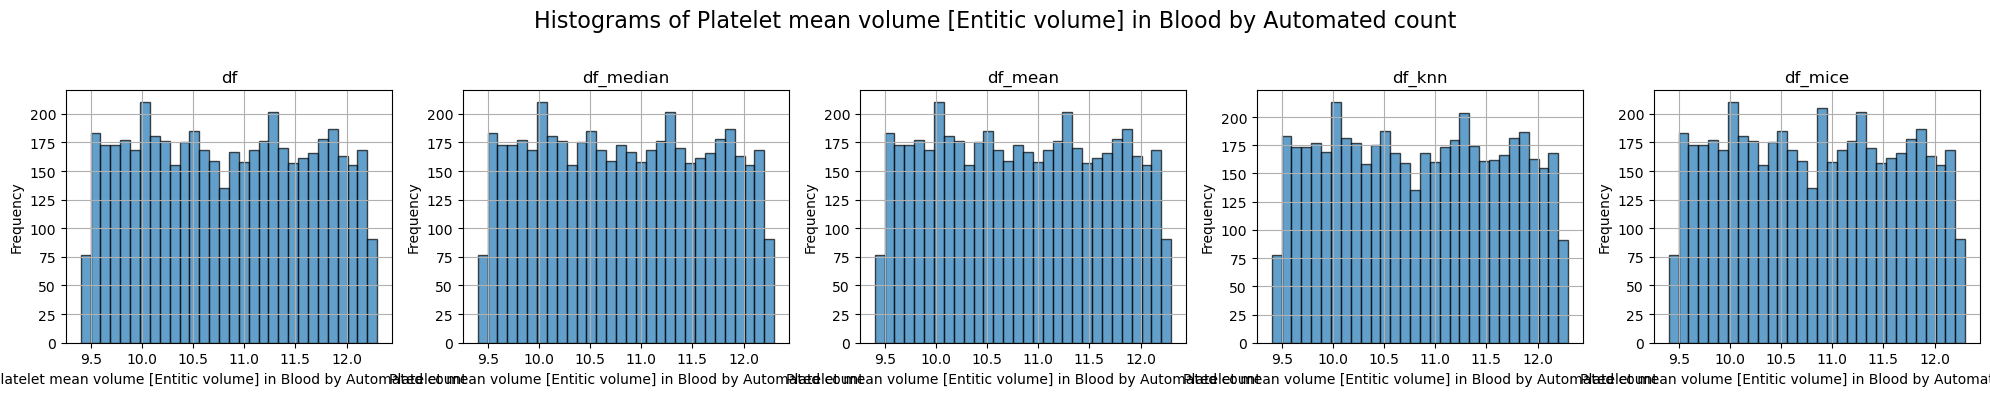

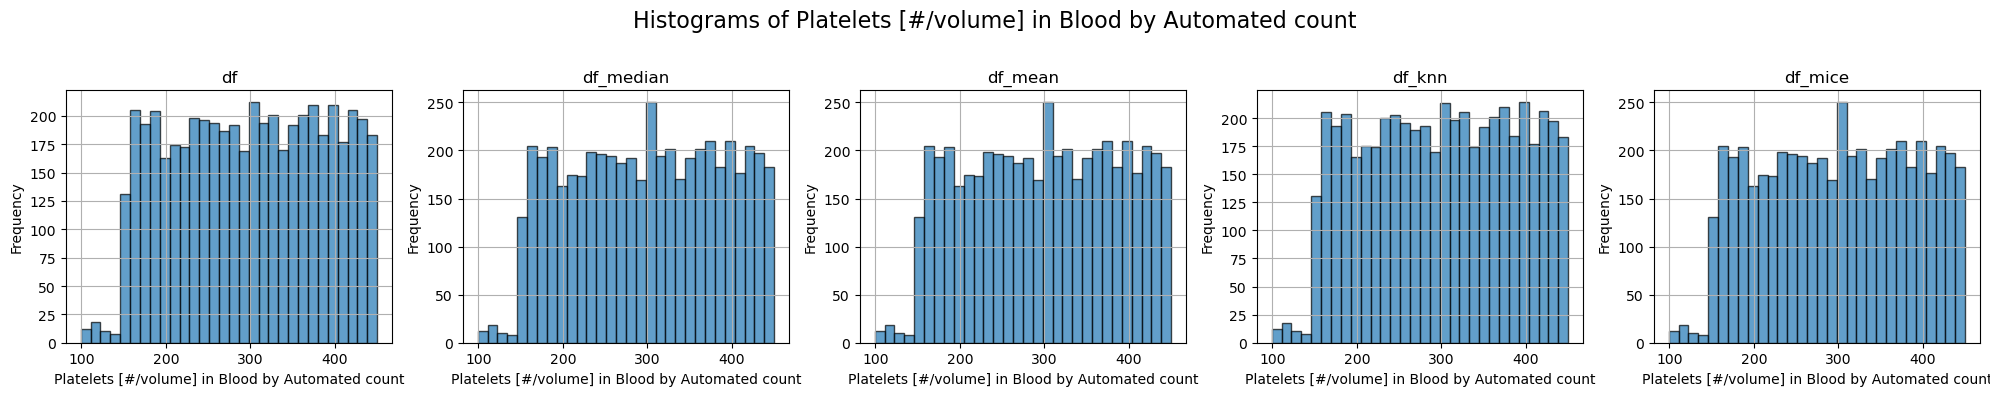

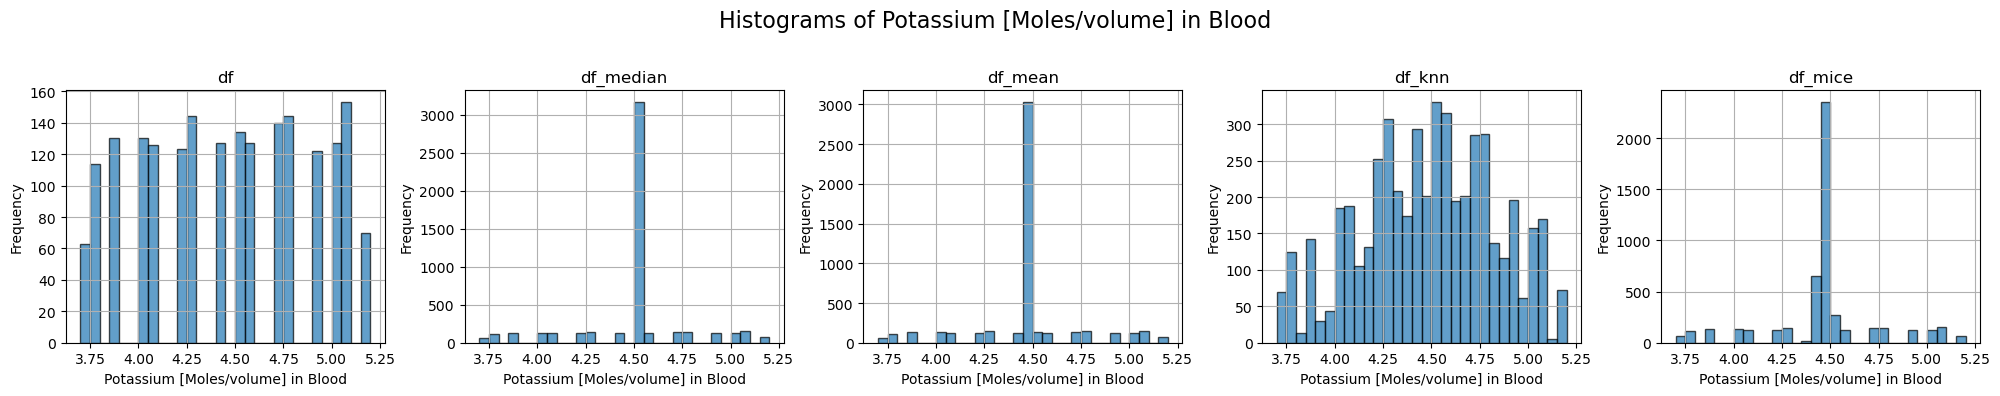

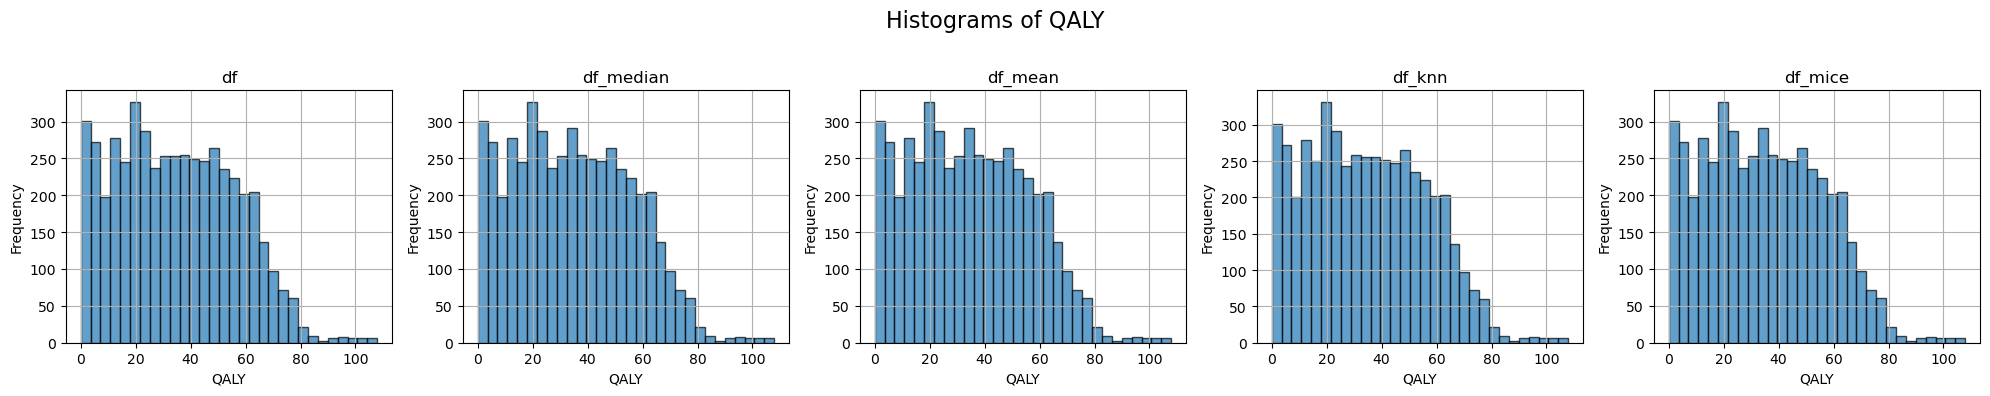

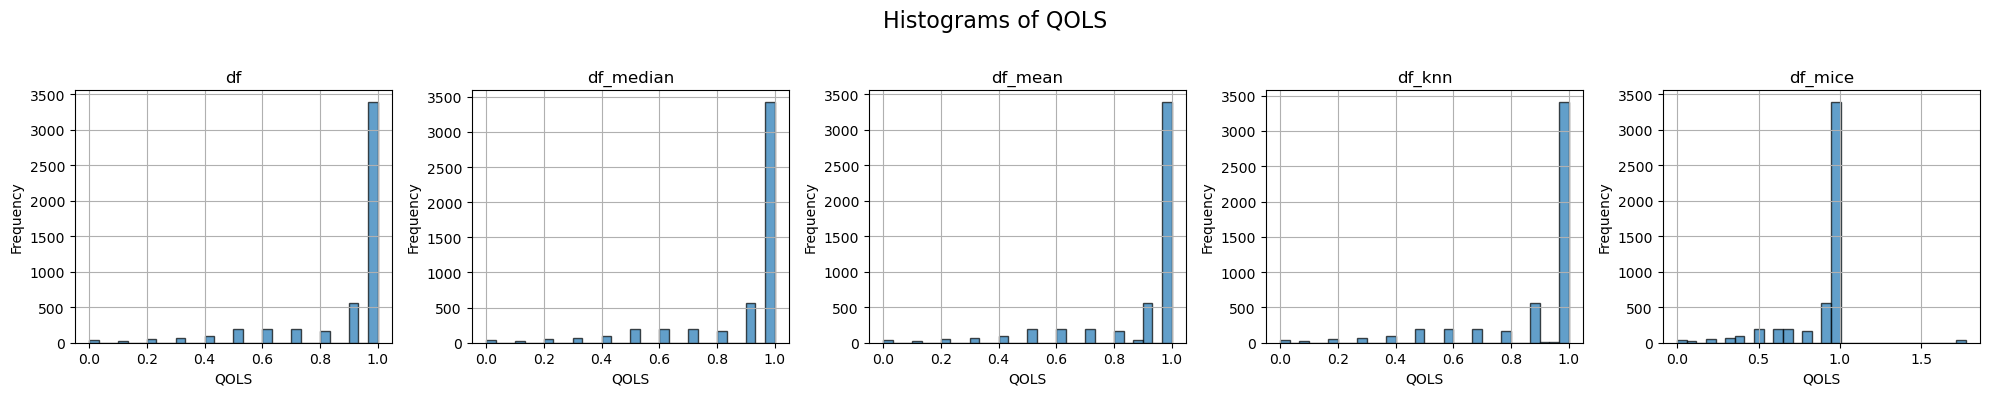

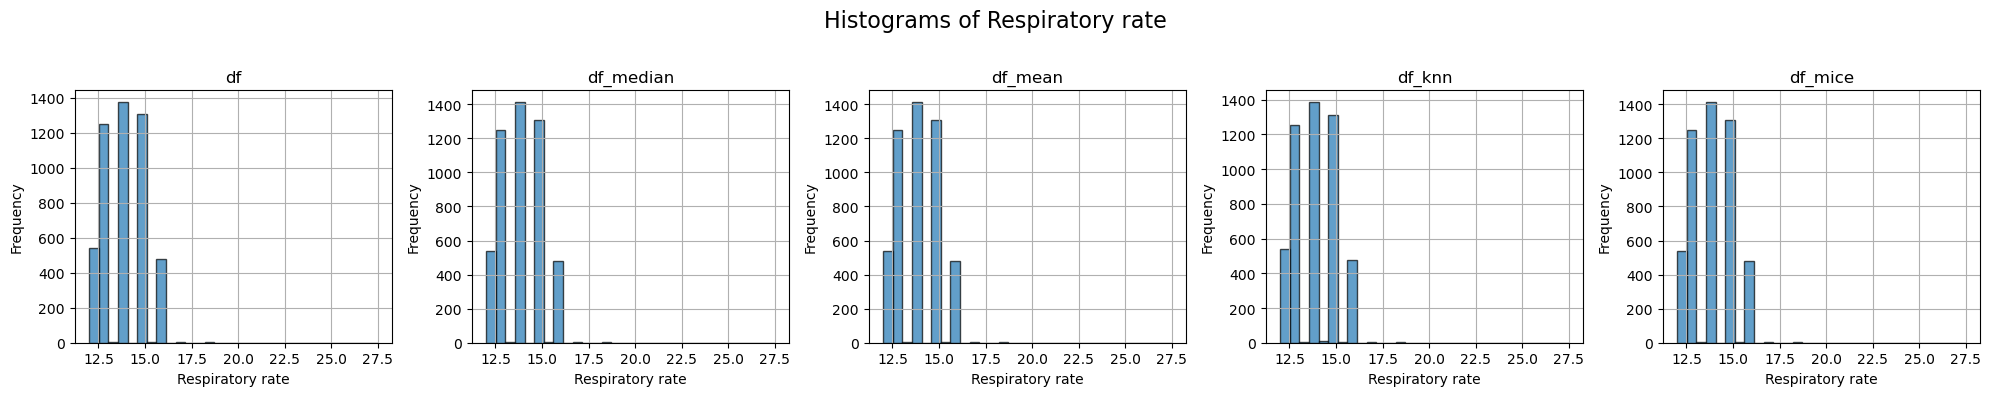

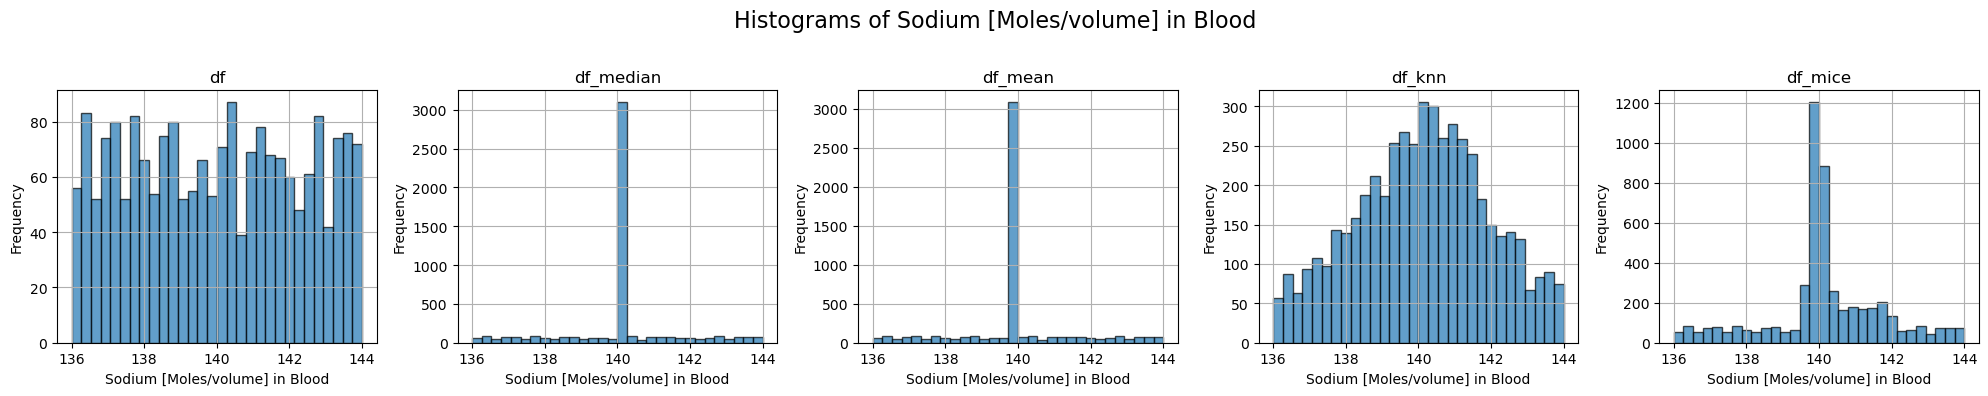

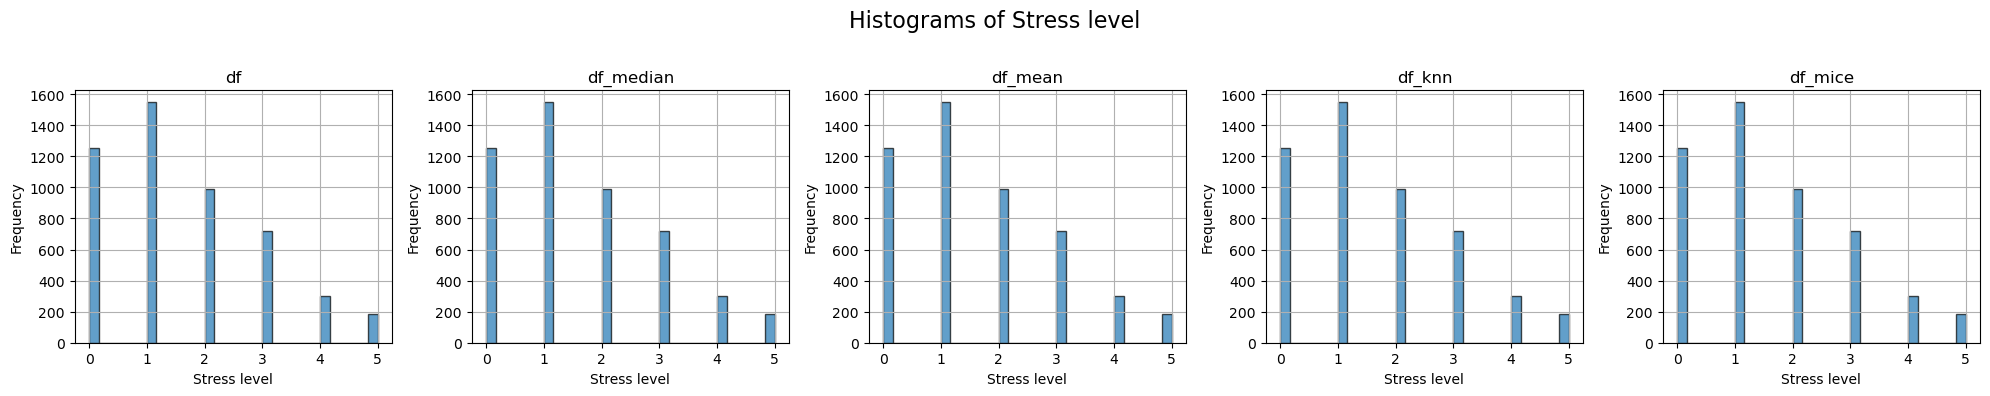

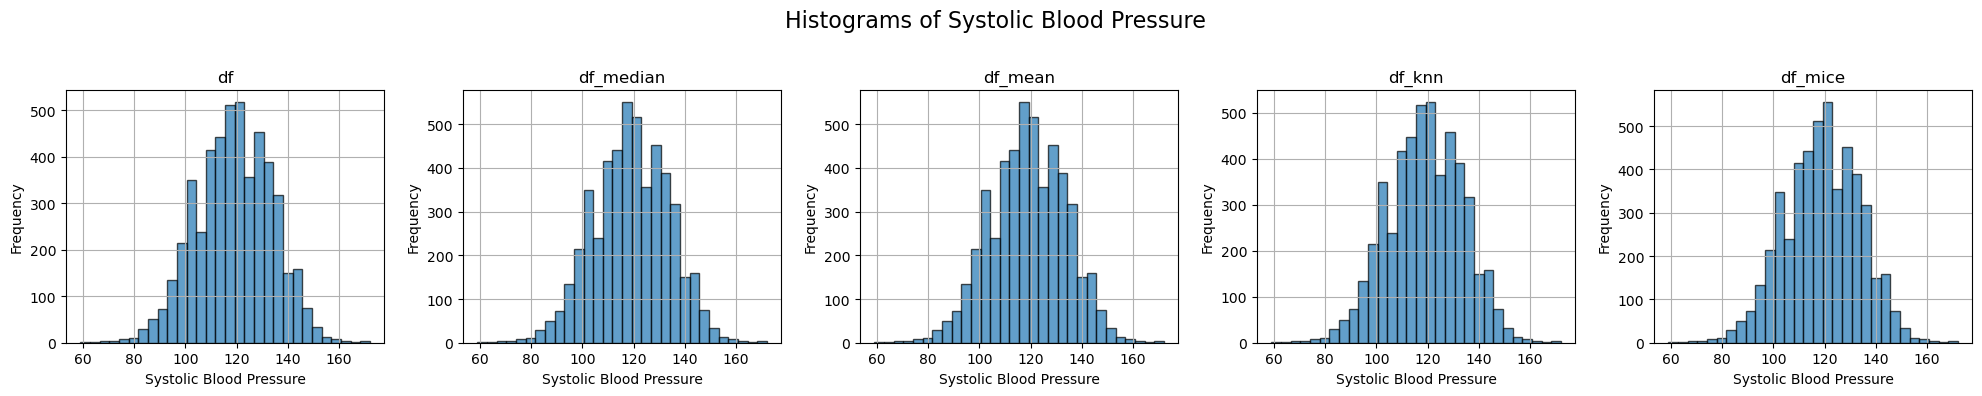

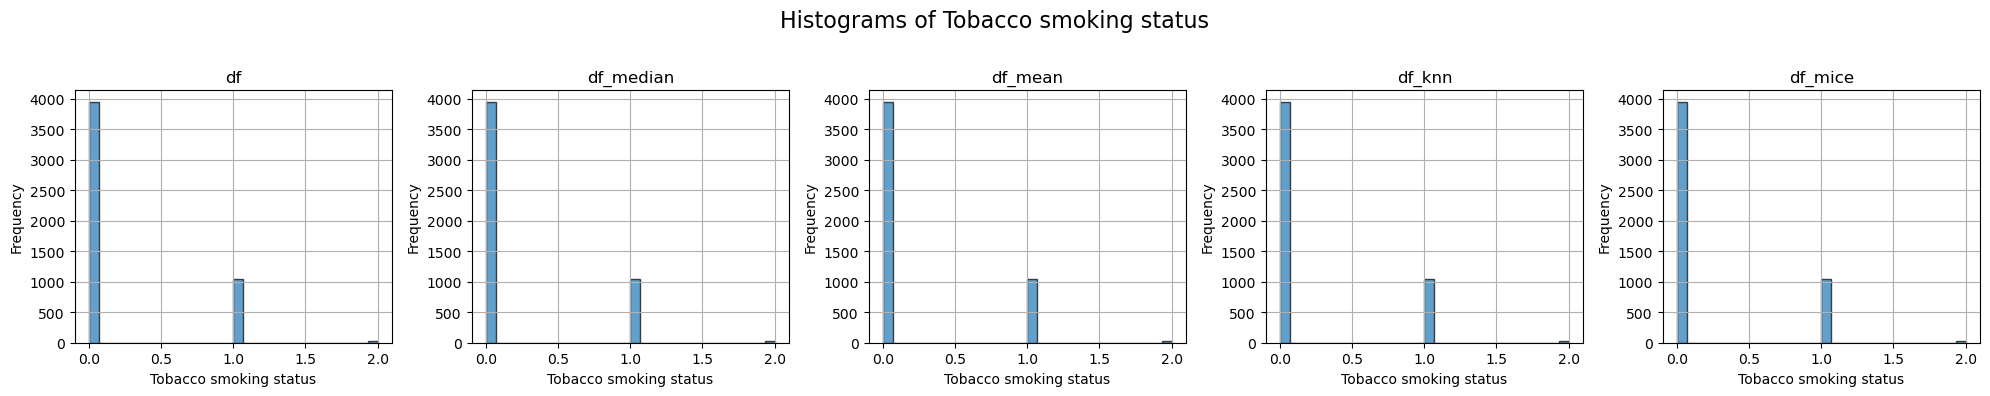

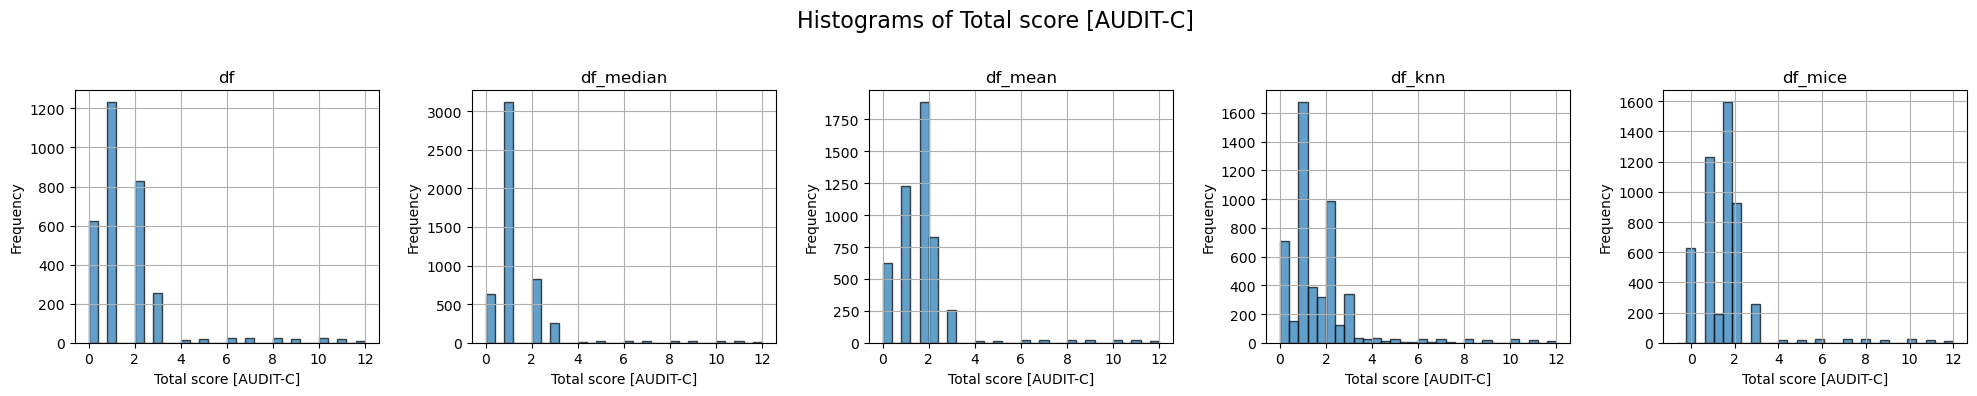

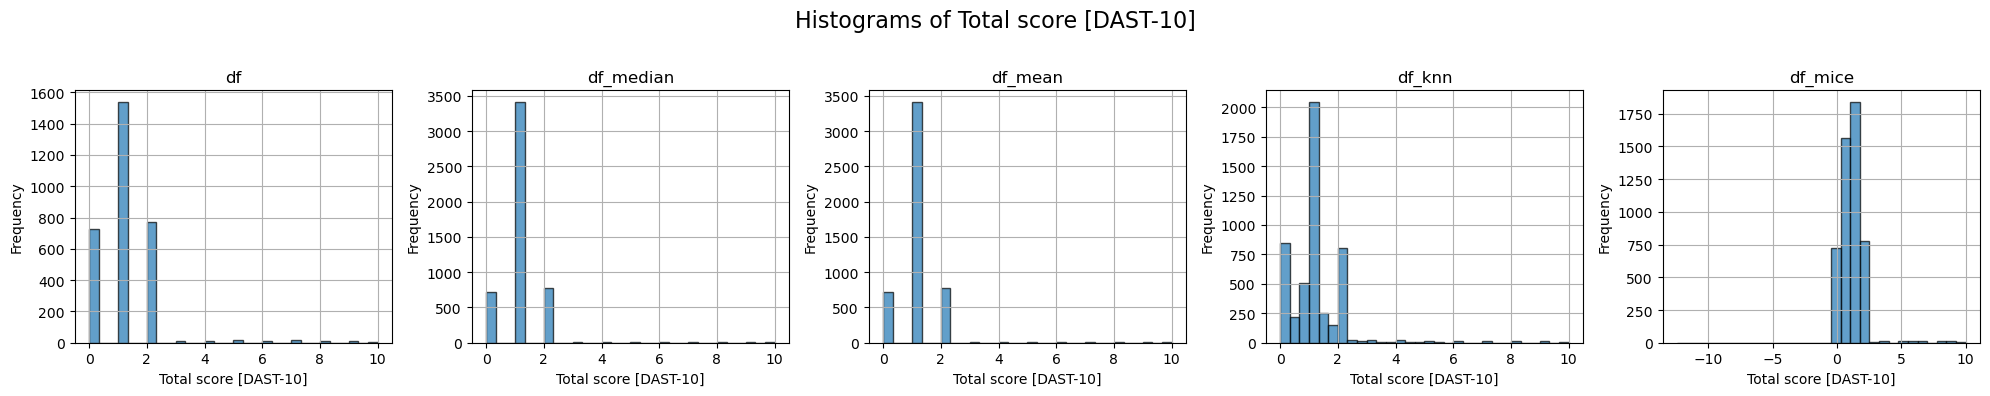

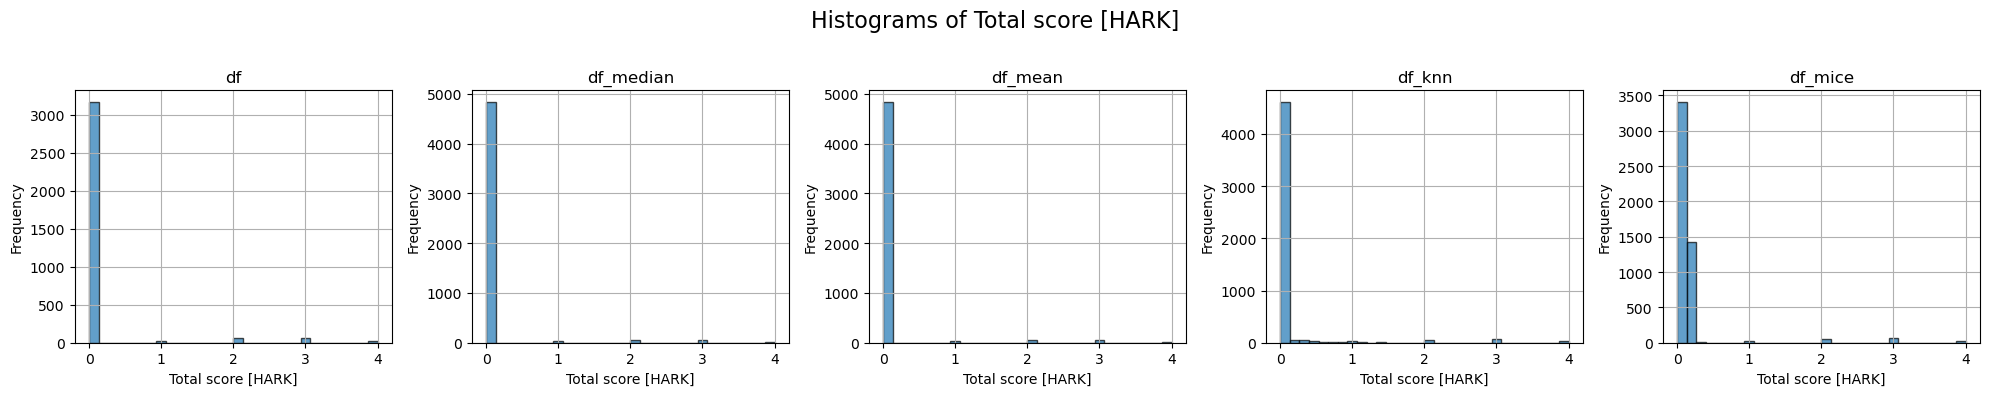

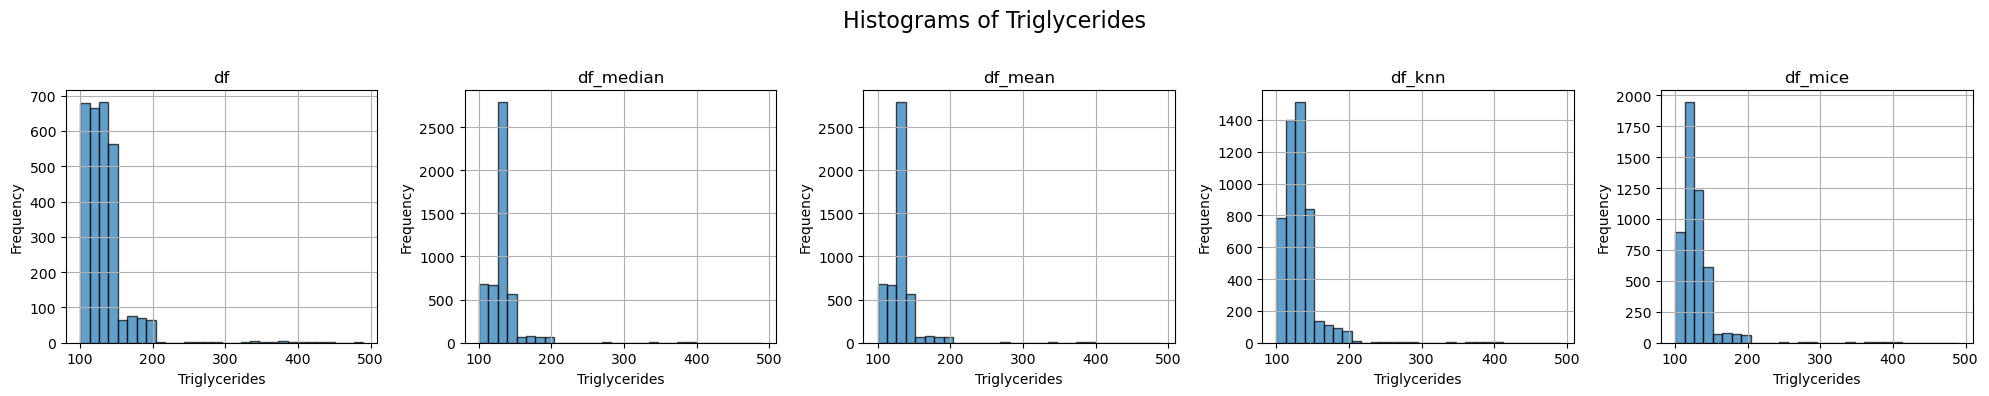

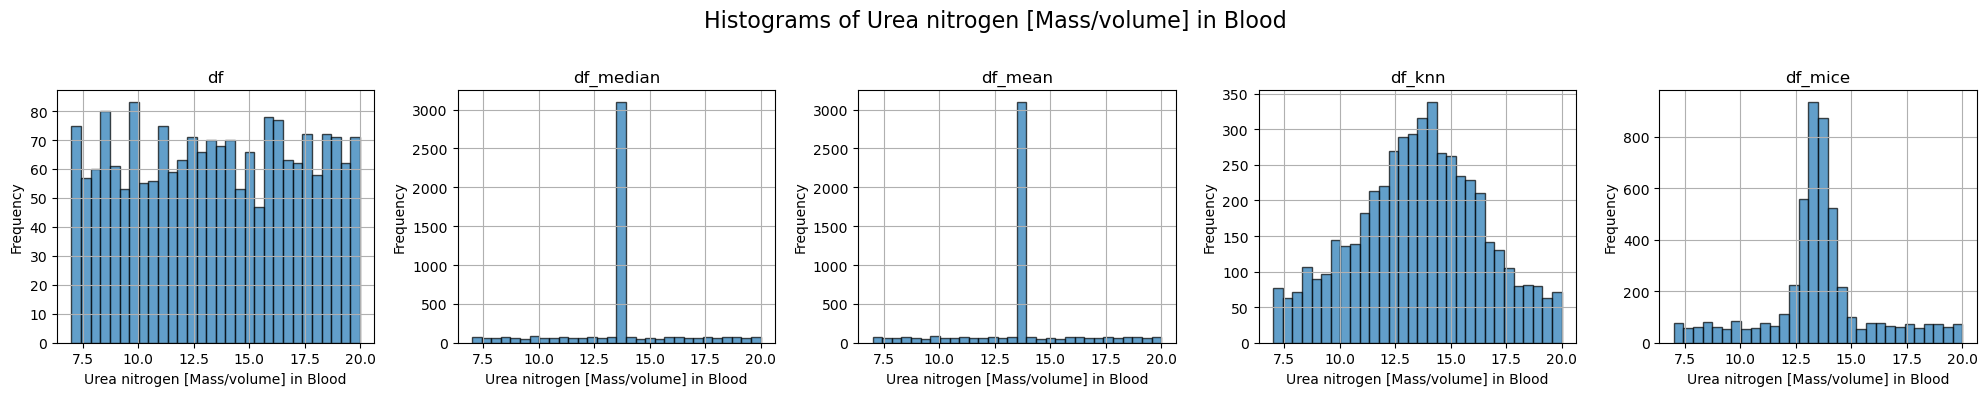

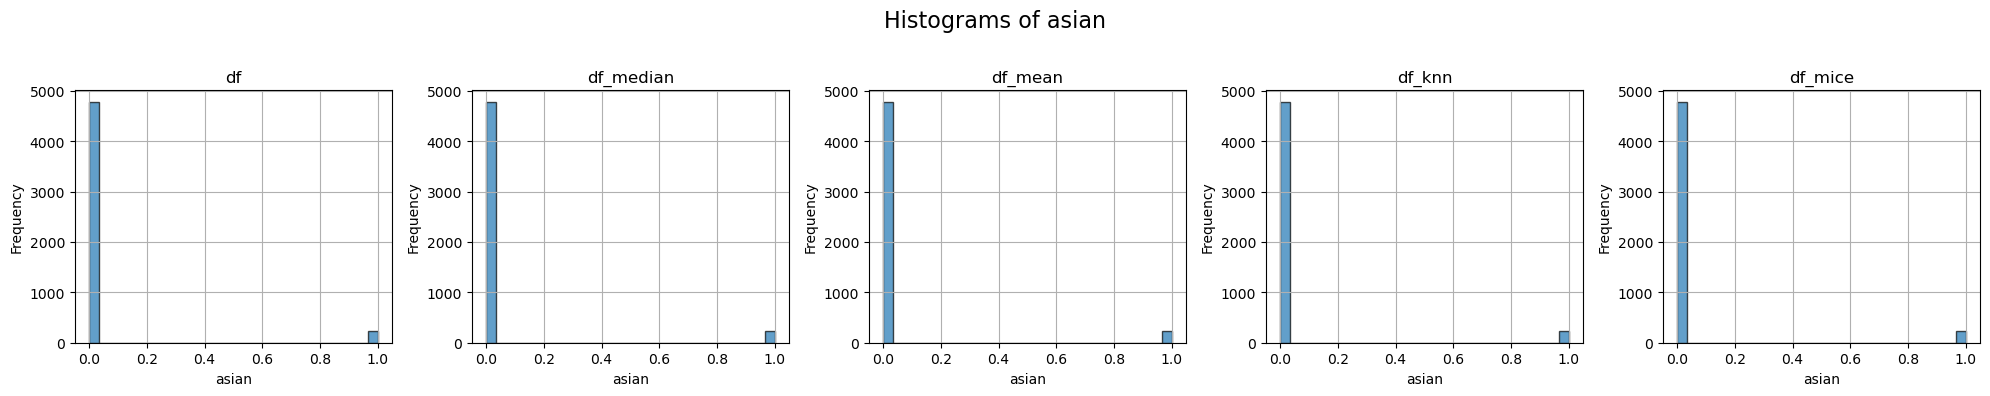

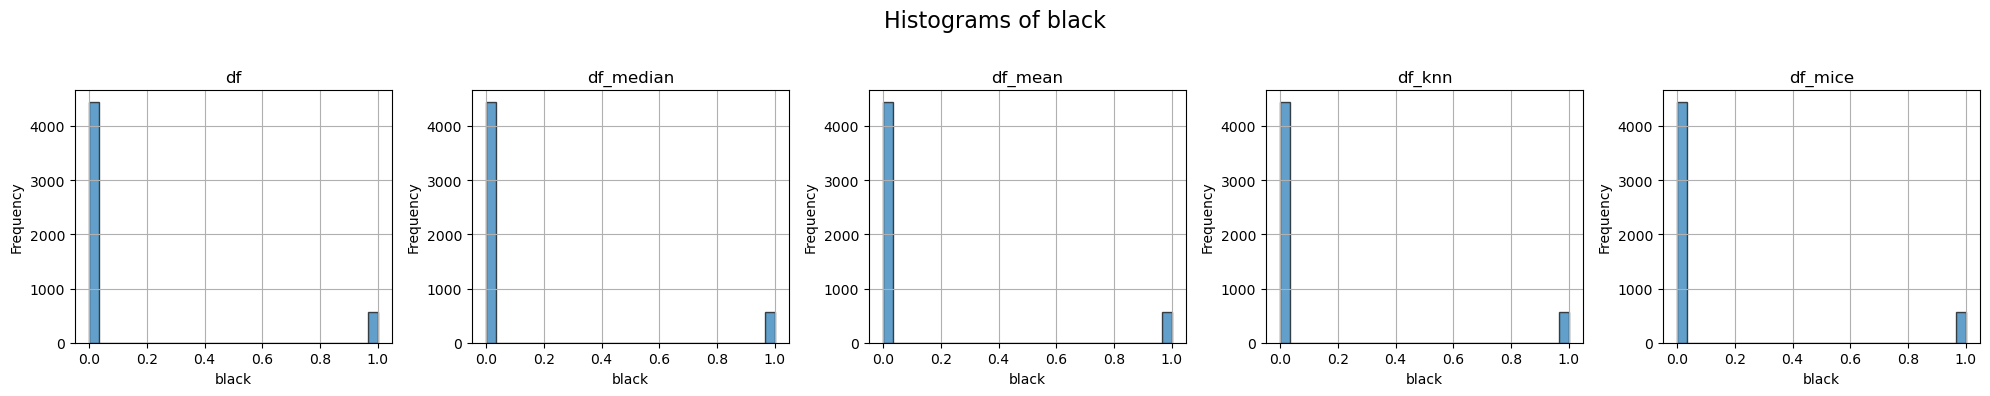

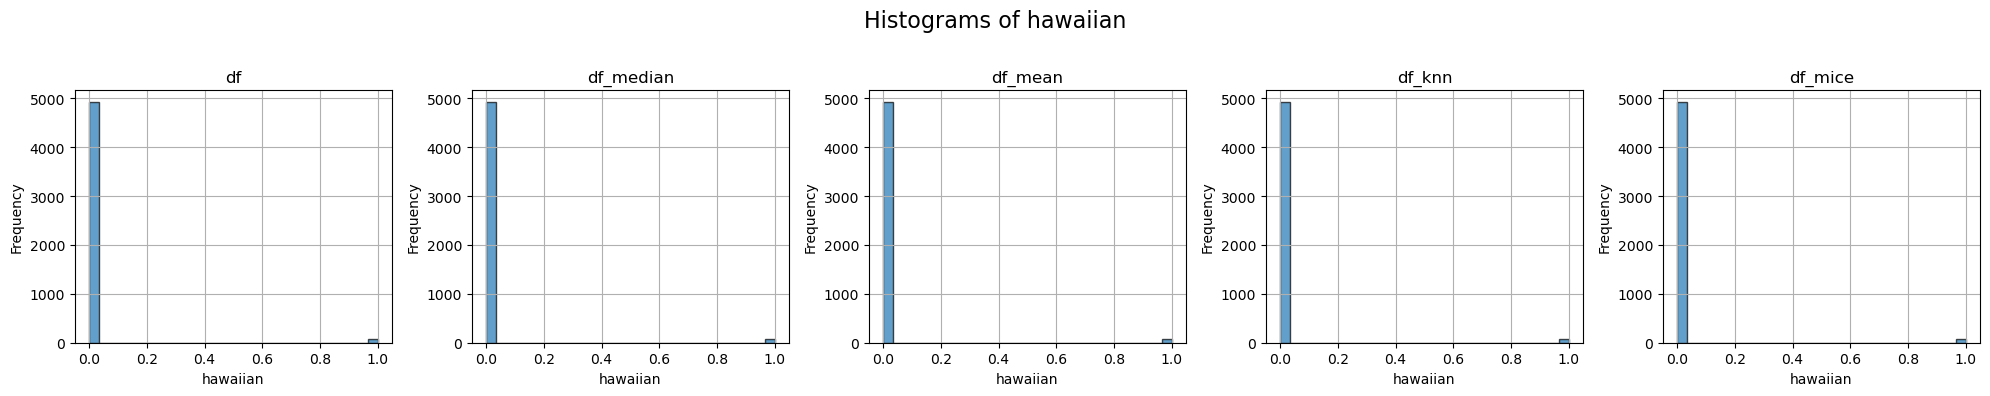

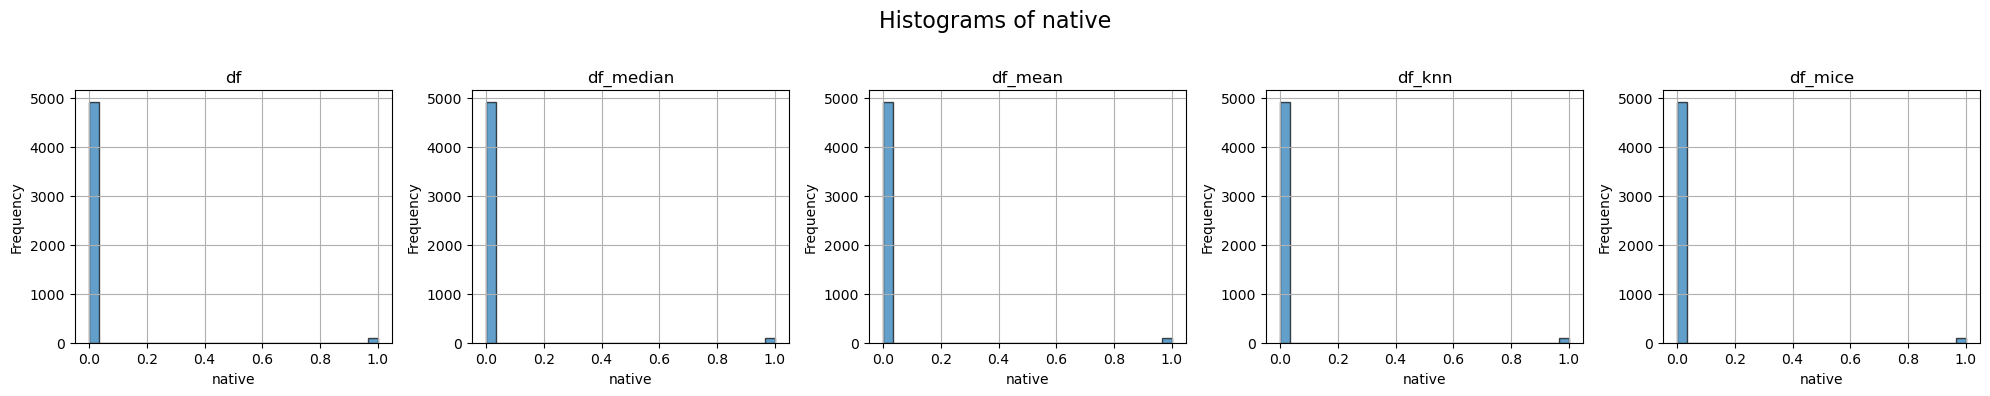

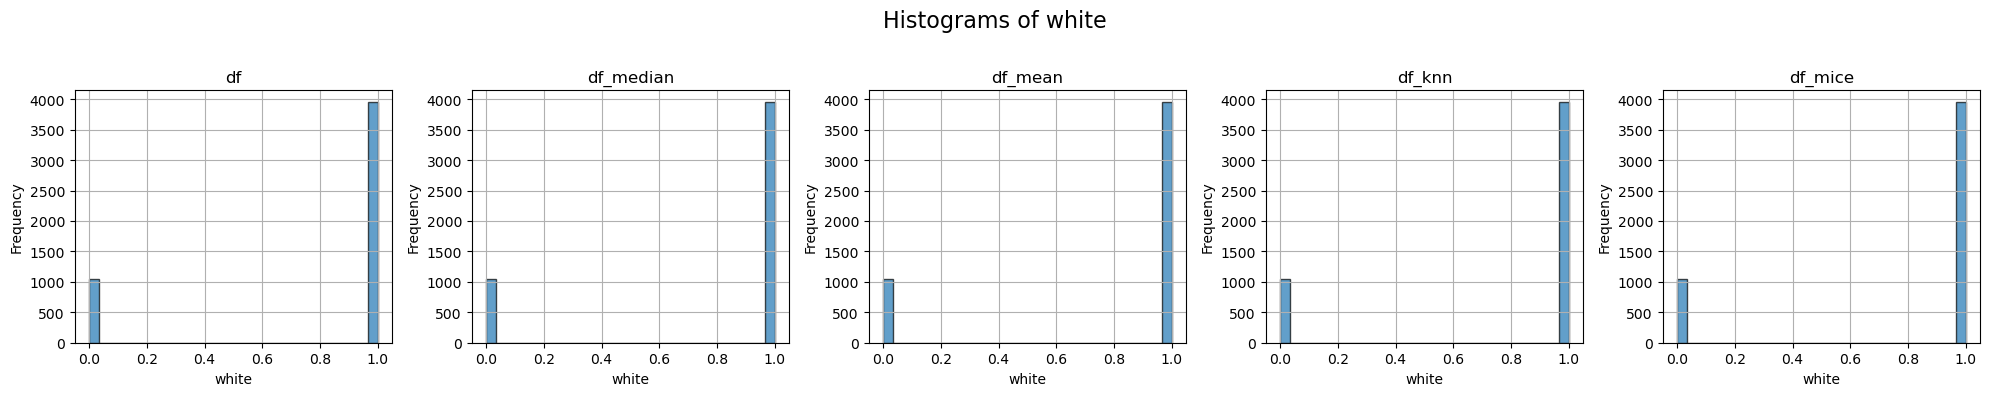

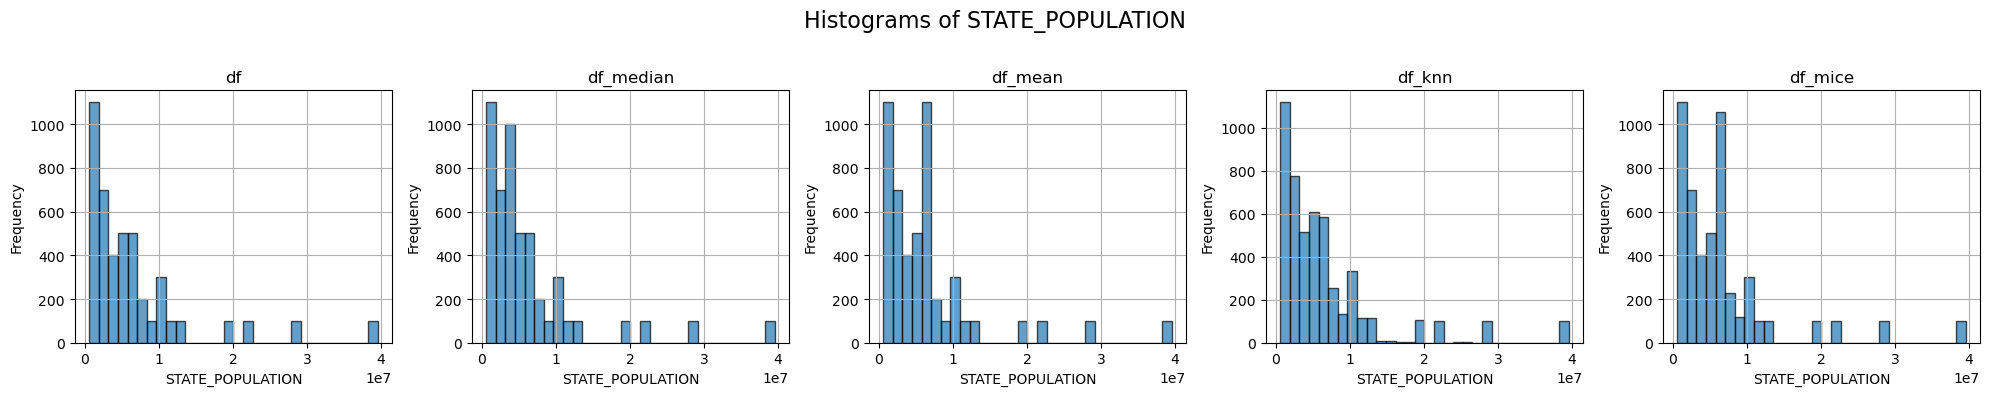

In [37]:
dataframes = [df, df_median, df_mean, df_knn, df_mice]
dataframe_names = ['df', 'df_median', 'df_mean', 'df_knn', 'df_mice']

num_dataframes = len(dataframes)

for column in dataframes[0].columns:
    fig, axes = plt.subplots(1, num_dataframes, figsize = (20, 4))
    
    for idx, (df, ax) in enumerate(zip(dataframes, axes)):
        ax.hist(df[column].dropna(), bins = 30, alpha = 0.7, edgecolor = 'black')
        
        ax.set_title(dataframe_names[idx])
        ax.set_xlabel(column)
        ax.set_ylabel('Frequency')
        ax.grid(True)
    
    plt.suptitle(f'Histograms of {column}', fontsize = 16)
    plt.tight_layout(rect = [0, 0, 1, 0.96])  
    plt.show()

In general, median, mean, and MICE imputation seems to create unimodal distributions that do not reflect the distribution of the original dataframe without imputed values. The KNN imputation method seems to make the distribution more normalized and is about the closest to the original distributions.

#### Principal component analysis (PCA)

PCA is performed to determine if dimensionality reduction should be considered.

In [41]:
def scale_pca(imputed_df, imputation_method):
    scaler = StandardScaler()
    imputed_df = imputed_df.drop(columns = ['encounters_cost'])
    imputed_df_scaled = scaler.fit_transform(imputed_df)

    imputed_df_pca = PCA().fit(imputed_df_scaled)

    plt.plot(imputed_df_pca.explained_variance_ratio_.cumsum())
    plt.xlabel('Component #')
    plt.ylabel('Cumulative variance ratio')
    plt.title('Cumulative variance ratio explained by PCA components using ' + imputation_method);

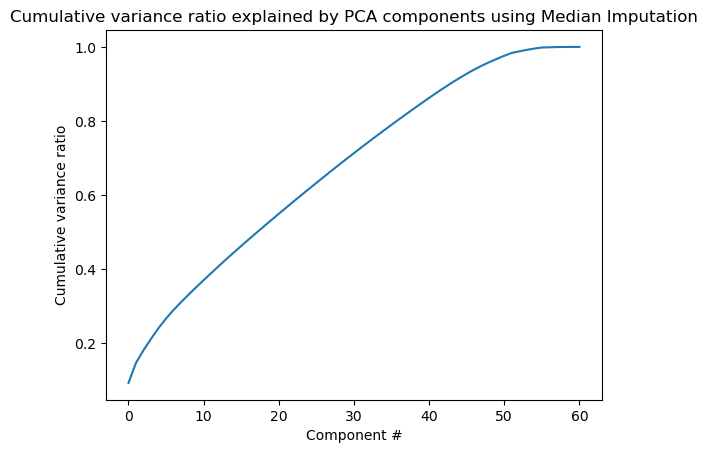

In [42]:
scale_pca(df_median, 'Median Imputation')

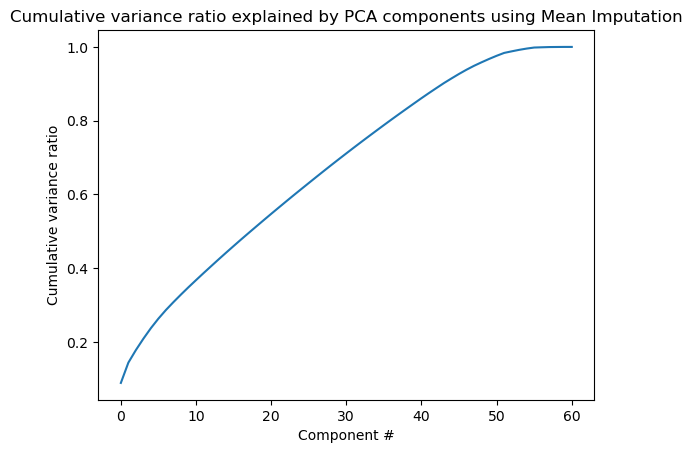

In [43]:
scale_pca(df_mean, 'Mean Imputation')

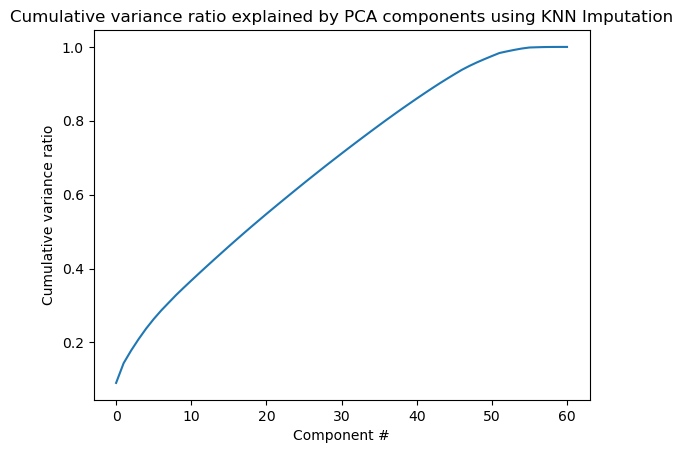

In [44]:
scale_pca(df_knn, 'KNN Imputation')

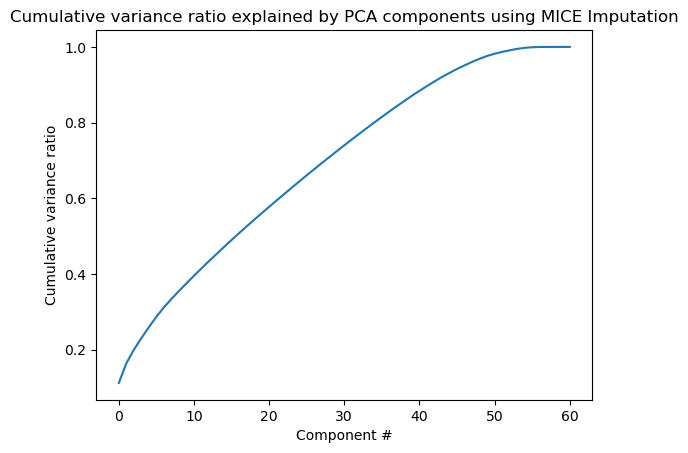

In [45]:
scale_pca(df_mice, 'MICE Imputation')

All imputation techniques showed that reducing the data to approximately 40 components would account for ~80% of the variance. This may be useful as the dataset has a lot of features, so reducing the dimensionality of the dataset may help with modeling and computation time.

The KNN imputation technique is selected as it produced the highest R squared score, resulted in somewhat normalized distributions of imputed variables, and had similar cumulative variance ratios to the other imputation techniques when performing PCA.

In [48]:
df_knn.to_csv('../data/synthea_knn.csv')

#### Dummy regression - mean value

To begin model development, the data is split into train and test sets, with 25% of the data reserved for testing.

In [51]:
X = df_knn.drop(columns = ['encounters_cost'])
y = df_knn['encounters_cost']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 123)

For a baseline model, the mean value is used as a predictor. This is performed using a dummy regressor.

In [53]:
train_mean = y_train.mean()
print(f'Mean value of training data: {train_mean:.2f}')

Mean value of training data: 15040.24


In [54]:
dumb_reg = DummyRegressor(strategy = 'mean')
dumb_reg.fit(X_train, y_train)
dumb_reg_constant = dumb_reg.constant_[0][0]
print(f'Dummy regressor constant value: {dumb_reg_constant:.2f}')

Dummy regressor constant value: 15040.24


The dummy regressor constant value is the same as the training mean, which is expected. The performance of this model is evaluated as a baseline comparison for future models.

In [56]:
y_train_pred = dumb_reg.predict(X_train)
y_test_pred = train_mean * np.ones(len(y_test))

In [57]:
def model_evaluation(y_train, y_train_pred, y_test, y_test_pred, title):
    print(title)
    print('')
    print('Training R squared:', round(r2_score(y_train, y_train_pred), 4))
    print('Testing R squared:', round(r2_score(y_test, y_test_pred), 4))
    print('')
    print('Training MAE:', round(mean_absolute_error(y_train, y_train_pred), 2))
    print('Testing MAE:', round(mean_absolute_error(y_test, y_test_pred), 2))
    print('')
    print('Training MSE:', round(mean_squared_error(y_train, y_train_pred), 2))
    print('Testing MSE:', round(mean_squared_error(y_test, y_test_pred),2))

The R squared value, mean absolute error (MAE) and mean squared error (MSE) are calculated for both the testing and training sets.

In [59]:
model_evaluation(y_train, y_train_pred, y_test, y_test_pred, 'Dummy regressor results:')

Dummy regressor results:

Training R squared: 0.0
Testing R squared: -0.0006

Training MAE: 18029.71
Testing MAE: 17276.07

Training MSE: 1214707483.91
Testing MSE: 1141617626.7


The R squared values are very low and the mean absolute error and mean squared error values are very high, showing that this is not a great fit for the model, as expected. These values will be saved to be compared to the final model.

In [61]:
dummy_train_r2 = r2_score(y_train, y_train_pred)
dummy_test_r2 = r2_score(y_test, y_test_pred)
dummy_train_mae = mean_absolute_error(y_train, y_train_pred)
dummy_test_mae = mean_absolute_error(y_test, y_test_pred)
dummy_train_mse = mean_squared_error(y_train, y_train_pred)
dummy_test_mse = mean_squared_error(y_test, y_test_pred)

#### Scaling the data

For future modeling steps, the data is scaled.

In [64]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Linear Regression

The first model that will be evaluated is a linear regression model.

In [67]:
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
y_train_pred = lr_model.predict(X_train_scaled)
y_test_pred = lr_model.predict(X_test_scaled)

model_evaluation(y_train, y_train_pred, y_test, y_test_pred, 'Initial linear regression model results:')

Initial linear regression model results:

Training R squared: 0.4593
Testing R squared: -0.1414

Training MAE: 13201.28
Testing MAE: 13054.11

Training MSE: 656793333.41
Testing MSE: 1302154678.52


A pipeline is created that selects the best features using f regression.

In [69]:
lr_pipe = make_pipeline(SelectKBest(f_regression), LinearRegression())
lr_pipe.fit(X_train_scaled, y_train)
y_train_pred = lr_pipe.predict(X_train_scaled)
y_test_pred = lr_pipe.predict(X_test_scaled)

model_evaluation(y_train, y_train_pred, y_test, y_test_pred, 'Linear regression pipeline model results:')

Linear regression pipeline model results:

Training R squared: 0.4088
Testing R squared: -0.2285

Training MAE: 12421.38
Testing MAE: 12127.61

Training MSE: 718177084.3
Testing MSE: 1401551547.03


Cross validation is performed to further understand the performance of the model. 

In [71]:
cv_results = cross_validate(lr_pipe, X_train_scaled, y_train, cv = 5, n_jobs = -1)
print('CV results (R squared values):', cv_results['test_score'])
print(f'Mean R squared: {cv_results['test_score'].mean():.4f}')
print(f'Standard deviation R squared: {cv_results['test_score'].std():.4f}')

CV results (R squared values): [0.37373951 0.28944352 0.33312654 0.47905679 0.4612446 ]
Mean R squared: 0.3873
Standard deviation R squared: 0.0729


A grid search is performed to determine the best number of features to include.

In [73]:
k = [k+1 for k in range(len(X_train.columns))]
grid_params = {'selectkbest__k': k}
lr_grid_cv = GridSearchCV(lr_pipe, param_grid = grid_params, cv = 5, n_jobs = -1)
lr_grid_cv.fit(X_train_scaled, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x000001E972AB1940>)),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1,
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12, 13, 14, 15, 16, 17, 18, 19, 20,
                                            21, 22, 23, 24, 25, 26, 27, 28, 29,
                                            30, ...]})

The means and standard deviations for the model with each k value are calculated and the best number of parameters is determined.

In [75]:
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]
lr_grid_cv.best_params_

{'selectkbest__k': 37}

According to the model, the optimal number of parameters is 37. This is visualized by plotting mean score versus number of parameters.

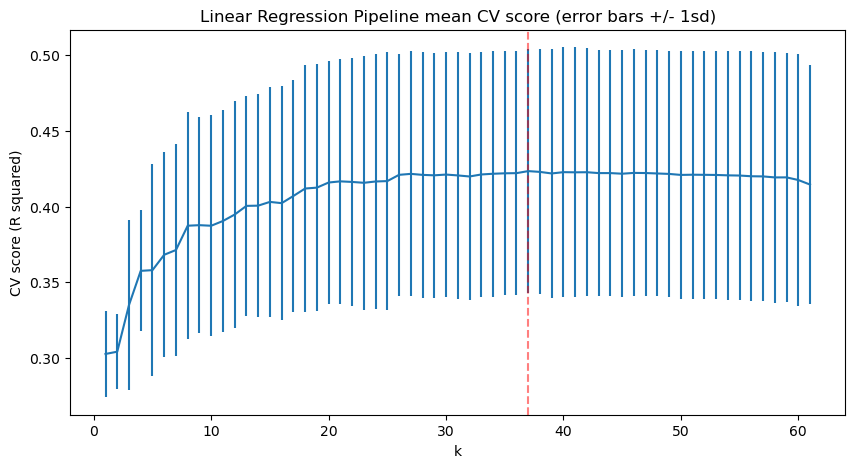

In [77]:
best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize = (10, 5))
plt.errorbar(cv_k, score_mean, yerr = score_std)
plt.axvline(x = best_k, c = 'r', ls = '--', alpha = 0.5)
plt.xlabel('k')
plt.ylabel('CV score (R squared)')
plt.title('Linear Regression Pipeline mean CV score (error bars +/- 1sd)');

The graph shows that the R squared value flattens out around 20 features, so it is not necessary to include 37.

In [79]:
lr_pipe_best = make_pipeline(SelectKBest(f_regression, k = 20), LinearRegression())
lr_pipe_best.fit(X_train_scaled, y_train)
y_train_pred = lr_pipe_best.predict(X_train_scaled)
y_test_pred = lr_pipe_best.predict(X_test_scaled)

model_evaluation(y_train, y_train_pred, y_test, y_test_pred, 'Linear regression pipeline model (k=20) results:')

Linear regression pipeline model (k=20) results:

Training R squared: 0.4464
Testing R squared: -0.1396

Training MAE: 13050.87
Testing MAE: 12799.56

Training MSE: 672463349.73
Testing MSE: 1300162762.67


Since the testing R squared value is lower than the training R squared value, it can be concluded that the model is overfitting. The negative R squared value for the testing data set shows that this model is not a good fit. However, it is an improvement over the dummy regressor prediction when comparing R squared, MAE, and MSE.

#### Ridge Regression

Next, a ridge regression model is tested. Different values of alpha are tested to assess various levels of controlling regularization strength.

In [83]:
ridge_scores = []
for alpha in [0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]:
    ridge = Ridge(alpha = alpha, random_state = 123)
    ridge.fit(X_train_scaled, y_train)
    ridge_pred = ridge.predict(X_test_scaled)
    ridge_scores.append(ridge.score(X_test_scaled, y_test))
print('Ridge scores:', ridge_scores)

Ridge scores: [-0.14151702028238788, -0.14037154417358577, -0.1286718476793014, -0.023616382052749074, 0.23209681042125385, 0.18651038937548603]


These scores are low, but the score with the alpha value of 1000 is the highest so that is selected. A pipeline is created that will select the best features using f regression.

In [85]:
ridge_pipe = make_pipeline(SelectKBest(f_regression), Ridge(alpha = 1000, random_state = 123))
ridge_pipe.fit(X_train_scaled, y_train)
y_train_pred = ridge_pipe.predict(X_train_scaled)
y_test_pred = ridge_pipe.predict(X_test_scaled)

model_evaluation(y_train, y_train_pred, y_test, y_test_pred, 'Ridge regression pipeline model results:')

Ridge regression pipeline model results:

Training R squared: 0.371
Testing R squared: 0.203

Training MAE: 12297.33
Testing MAE: 11862.1

Training MSE: 764025987.86
Testing MSE: 909252140.06


Cross validation is performed to further understand the performance of the model. 

In [87]:
cv_results = cross_validate(ridge_pipe, X_train_scaled, y_train, cv = 5, n_jobs = -1)
print('CV results (R squared values):', cv_results['test_score'])
print(f'Mean R squared: {cv_results['test_score'].mean():.4f}')
print(f'Standard deviation R squared: {cv_results['test_score'].std():.4f}')

CV results (R squared values): [0.34333874 0.30196278 0.32491548 0.40857796 0.38311561]
Mean R squared: 0.3524
Standard deviation R squared: 0.0387


A grid search is performed to determine the best number of features to include.

In [89]:
k = [k+1 for k in range(len(X_train.columns))]
grid_params = {'selectkbest__k': k}
ridge_grid_cv = GridSearchCV(ridge_pipe, param_grid = grid_params, cv = 5, n_jobs = -1)
ridge_grid_cv.fit(X_train_scaled, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x000001E972AB1940>)),
                                       ('ridge',
                                        Ridge(alpha=1000, random_state=123))]),
             n_jobs=-1,
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12, 13, 14, 15, 16, 17, 18, 19, 20,
                                            21, 22, 23, 24, 25, 26, 27, 28, 29,
                                            30, ...]})

The means and standard deviations for the model with each k value are calculated and the best number of parameters is determined.

In [91]:
score_mean = ridge_grid_cv.cv_results_['mean_test_score']
score_std = ridge_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in ridge_grid_cv.cv_results_['param_selectkbest__k']]
ridge_grid_cv.best_params_

{'selectkbest__k': 46}

According to the model, the optimal number of parameters is 46. This will be visualized by plotting mean score versus number of parameters.

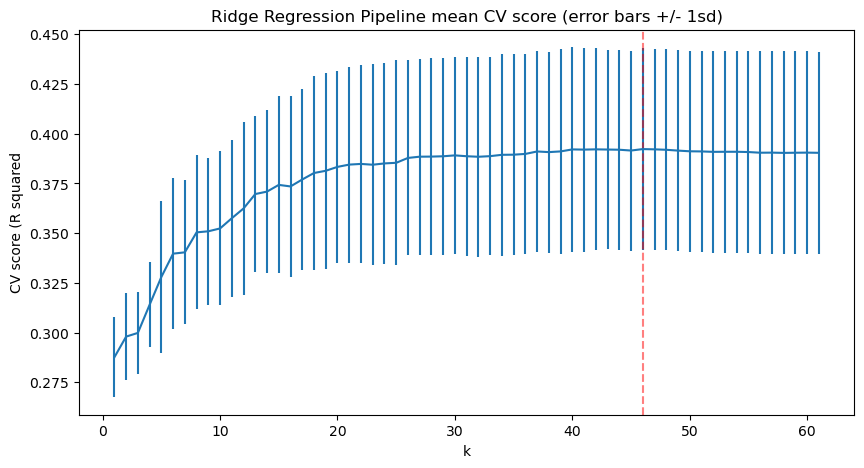

In [93]:
best_k = ridge_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr = score_std)
plt.axvline(x = best_k, c = 'r', ls = '--', alpha = 0.5)
plt.xlabel('k')
plt.ylabel('CV score (R squared')
plt.title('Ridge Regression Pipeline mean CV score (error bars +/- 1sd)');

Just like the linear regression model, the graph shows that the R squared value flattens out around 20 features, so it is not necessary to include 46.

In [95]:
ridge_pipe_best = make_pipeline(SelectKBest(f_regression, k = 20), Ridge(alpha = 1000, random_state = 123))
ridge_pipe_best.fit(X_train_scaled, y_train)
y_train_pred = ridge_pipe_best.predict(X_train_scaled)
y_test_pred = ridge_pipe_best.predict(X_test_scaled)

model_evaluation(y_train, y_train_pred, y_test, y_test_pred, 'Ridge regression pipeline model (k=20) results:')

Ridge regression pipeline model (k=20) results:

Training R squared: 0.4073
Testing R squared: 0.2567

Training MAE: 12431.39
Testing MAE: 12021.69

Training MSE: 719984233.37
Testing MSE: 848007970.02


Since the testing R squared value is lower than the training R squared value, it can be concluded that the model is  overfitting. This model is a slight improvement over the linear regression model when comparing R squared, MAE, and MSE, but it is still not great.

#### Lasso regression

Next, a lasso regression model will be tested. Different values of alpha are tested to assess various levels of controlling regularization strength.

In [99]:
lasso_scores = []
for alpha in [0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]:
    lasso = Lasso(alpha = alpha, random_state = 123)
    lasso.fit(X_train_scaled, y_train)
    lasso_pred = lasso.predict(X_test_scaled)
    lasso_scores.append(lasso.score(X_test_scaled, y_test))
print('Lasso scores:', lasso_scores)

Lasso scores: [-0.14153749864316434, -0.14058136159579493, -0.13069540479250374, -0.04953280612833755, 0.4176216291256739, 0.23535887271700884]


These scores are pretty low, but the score with the alpha value of 1000 is the highest so that is selected. A pipeline is created that will select the best features using f regression.

In [101]:
lasso_pipe = make_pipeline(SelectKBest(f_regression), Lasso(alpha = 1000, random_state = 123))
lasso_pipe.fit(X_train_scaled, y_train)
y_train_pred = lasso_pipe.predict(X_train_scaled)
y_test_pred = lasso_pipe.predict(X_test_scaled)

model_evaluation(y_train, y_train_pred, y_test, y_test_pred, 'Lasso regression pipeline model results:')

Lasso regression pipeline model results:

Training R squared: 0.3924
Testing R squared: 0.381

Training MAE: 12037.23
Testing MAE: 11391.24

Training MSE: 738066713.9
Testing MSE: 706159807.47


Cross validation is performed to further understand the performance of the model. 

In [103]:
cv_results = cross_validate(lasso_pipe, X_train_scaled, y_train, cv = 5, n_jobs = -1)
print('CV results (R squared values):', cv_results['test_score'])
print(f'Mean R squared: {cv_results['test_score'].mean():.4f}')
print(f'Standard deviation R squared: {cv_results['test_score'].std():.4f}')

CV results (R squared values): [0.35431658 0.3168299  0.32811507 0.44926458 0.42209158]
Mean R squared: 0.3741
Standard deviation R squared: 0.0524


A grid search will be performed to determine the best number of features to include.

In [105]:
k = [k+1 for k in range(len(X_train.columns))]
grid_params = {'selectkbest__k': k}
lasso_grid_cv = GridSearchCV(lasso_pipe, param_grid = grid_params, cv = 5, n_jobs = -1)
lasso_grid_cv.fit(X_train_scaled, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x000001E972AB1940>)),
                                       ('lasso',
                                        Lasso(alpha=1000, random_state=123))]),
             n_jobs=-1,
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12, 13, 14, 15, 16, 17, 18, 19, 20,
                                            21, 22, 23, 24, 25, 26, 27, 28, 29,
                                            30, ...]})

The means and standard deviations for the model with each k value are calculated and the best number of parameters is determined.

In [107]:
score_mean = lasso_grid_cv.cv_results_['mean_test_score']
score_std = lasso_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lasso_grid_cv.cv_results_['param_selectkbest__k']]
lasso_grid_cv.best_params_

{'selectkbest__k': 43}

According to the model, the optimal number of parameters is 43. This will be visualized by plotting mean score versus number of parameters.

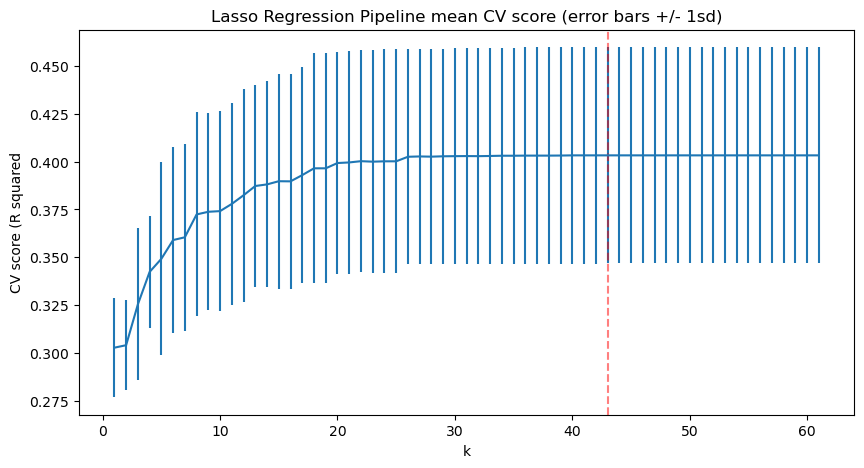

In [109]:
best_k = lasso_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr = score_std)
plt.axvline(x = best_k, c = 'r', ls = '--', alpha = 0.5)
plt.xlabel('k')
plt.ylabel('CV score (R squared')
plt.title('Lasso Regression Pipeline mean CV score (error bars +/- 1sd)');

Once again, the graph shows that the R squared value flattens out around 20 features, so it is not necessary to include 43.

In [111]:
lasso_pipe_best = make_pipeline(SelectKBest(f_regression, k = 20), Lasso(alpha = 1000, random_state = 123))
lasso_pipe_best.fit(X_train_scaled, y_train)
y_train_pred = lasso_pipe_best.predict(X_train_scaled)
y_test_pred = lasso_pipe_best.predict(X_test_scaled)

model_evaluation(y_train, y_train_pred, y_test, y_test_pred, 'Lasso regression pipeline model (k=20) results:')

Lasso regression pipeline model (k=20) results:

Training R squared: 0.4223
Testing R squared: 0.4184

Training MAE: 12130.95
Testing MAE: 11354.02

Training MSE: 701754831.8
Testing MSE: 663539670.31


The testing R squared value is closer to the training R squared model, suggesting this model performed well with the testing data and is not overfitting to the training data. However, these R squared scores are quite low. This model is a slight improvement over the ridge regression model when comparing R squared, MAE, and MSE.

#### Random forest

Next, a random forest model will be evaluated.

In [115]:
rf_model = make_pipeline(SelectKBest(f_regression), RandomForestRegressor(random_state = 123))
rf_model.fit(X_train_scaled, y_train)
y_train_pred = rf_model.predict(X_train_scaled)
y_test_pred = rf_model.predict(X_test_scaled)

model_evaluation(y_train, y_train_pred, y_test, y_test_pred, 'Initial random forest model results:')

Initial random forest model results:

Training R squared: 0.9488
Testing R squared: 0.6428

Training MAE: 2418.14
Testing MAE: 6165.2

Training MSE: 62251293.24
Testing MSE: 407553868.95


Cross validation is performed to further understand the performance of the model.

In [117]:
cv_results = cross_validate(rf_model, X_train_scaled, y_train, cv = 5, n_jobs = -1)
print('CV results (R squared values):', cv_results['test_score'])
print(f'Mean R squared: {cv_results['test_score'].mean():.4f}')
print(f'Standard deviation R squared: {cv_results['test_score'].std():.4f}')

CV results (R squared values): [0.76965999 0.49384554 0.58482465 0.78929566 0.77290919]
Mean R squared: 0.6821
Standard deviation R squared: 0.1203


A grid search is performed to determine the best number of features to include (k) and the optimal number of trees in the random forest (n_est).

In [119]:
k = list(range(10, 61, 5))
n_est = list(range(10, 101, 10))
grid_params = {'selectkbest__k': k, 'randomforestregressor__n_estimators': n_est}
rf_grid_cv = GridSearchCV(rf_model, param_grid = grid_params, cv = 5, n_jobs = -1)
rf_grid_cv.fit(X_train_scaled, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x000001E972AB1940>)),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=123))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__n_estimators': [10, 20, 30, 40,
                                                                 50, 60, 70, 80,
                                                                 90, 100],
                         'selectkbest__k': [10, 15, 20, 25, 30, 35, 40, 45, 50,
                                            55, 60]})

The means and standard deviations for the model with each k and n_est value are calculated and the best number of parameters and number of trees are determined.

In [121]:
score_mean = rf_grid_cv.cv_results_['mean_test_score']
score_std = rf_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in rf_grid_cv.cv_results_['param_selectkbest__k']]
cv_n_est = [n_est for n_est in rf_grid_cv.cv_results_['param_randomforestregressor__n_estimators']]
rf_grid_cv.best_params_

{'randomforestregressor__n_estimators': 80, 'selectkbest__k': 45}

According to the model, the optimal number of trees is 80 and the optimal number of parameters to include is 45. These are visualized by plotting mean score versus number of trees and number of parameters.

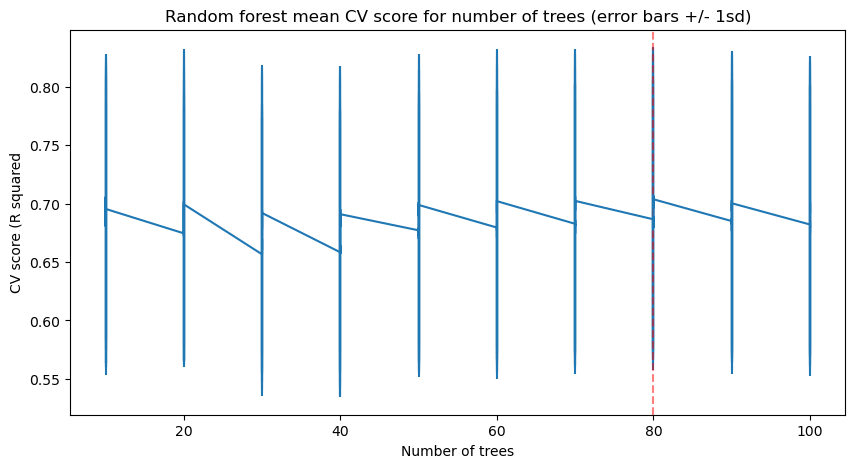

In [123]:
best_cv_n_est = rf_grid_cv.best_params_['randomforestregressor__n_estimators']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_n_est, score_mean, yerr = score_std)
plt.axvline(x = best_cv_n_est, c = 'r', ls = '--', alpha = 0.5)
plt.xlabel('Number of trees')
plt.ylabel('CV score (R squared')
plt.title('Random forest mean CV score for number of trees (error bars +/- 1sd)');

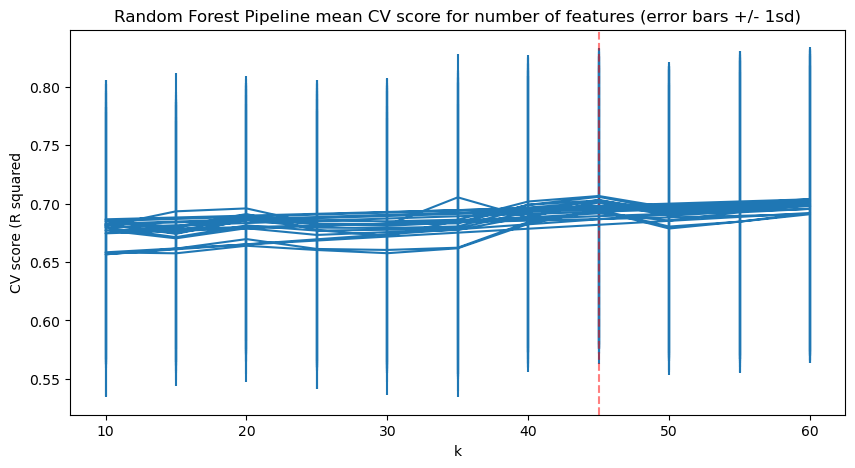

In [124]:
best_k = rf_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr = score_std)
plt.axvline(x = best_k, c = 'r', ls = '--', alpha = 0.5)
plt.xlabel('k')
plt.ylabel('CV score (R squared')
plt.title('Random Forest Pipeline mean CV score for number of features (error bars +/- 1sd)');

In [125]:
rf_model_best = make_pipeline(SelectKBest(f_regression, k = 45), RandomForestRegressor(n_estimators = 80, random_state = 123))
rf_model_best.fit(X_train_scaled, y_train)
y_train_pred = rf_model_best.predict(X_train_scaled)
y_test_pred = rf_model_best.predict(X_test_scaled)

model_evaluation(y_train, y_train_pred, y_test, y_test_pred, 'Random forest model (k=45, trees=80) results:')

Random forest model (k=45, trees=80) results:

Training R squared: 0.9426
Testing R squared: 0.635

Training MAE: 2519.64
Testing MAE: 6167.8

Training MSE: 69728646.81
Testing MSE: 416450743.75


This is a great improvement compared to the lasso regression model in terms of R squared, MAE, and MSE. The training R squared is lower than the testing R squared, and the training MAE/MSE are lower than the testing MAE/MSE, which suggests overfitting.

Cross validation is performed to further understand the performance of the model.

In [128]:
cv_results = cross_validate(rf_model_best, X_train_scaled, y_train, cv = 5, n_jobs = -1)
print('CV results (R squared values):', cv_results['test_score'])
print(f'Mean R squared: {cv_results['test_score'].mean():.4f}')
print(f'Standard deviation R squared: {cv_results['test_score'].std():.4f}')

CV results (R squared values): [0.79574719 0.46598884 0.71258555 0.73828826 0.81996411]
Mean R squared: 0.7065
Standard deviation R squared: 0.1263


The top features are listed by importance.

In [130]:
selected = rf_grid_cv.best_estimator_.named_steps.selectkbest.get_support()
coefs = rf_grid_cv.best_estimator_.named_steps.randomforestregressor.feature_importances_
features = X_train.columns[selected]
pd.Series(coefs, index = features).sort_values(ascending = False)

num_encounters                                                              0.462398
num_procedures                                                              0.077079
DALY                                                                        0.064998
Leukocytes [#/volume] in Blood by Automated count                           0.060053
Glomerular filtration rate/1.73 sq M.predicted [Volume Rate/Area]           0.039946
AGE                                                                         0.039536
Chloride [Moles/volume] in Blood                                            0.025545
meds_cost                                                                   0.019654
Pain severity - 0-10 verbal numeric rating [Score] - Reported               0.014533
num_meds                                                                    0.014139
QALY                                                                        0.012318
Potassium [Moles/volume] in Blood                                

The model r squared, MAE, and MSE scores are saved to compare to the dummy regressor model.

In [132]:
rf_train_r2 = r2_score(y_train, y_train_pred)
rf_test_r2 = r2_score(y_test, y_test_pred)
rf_train_mae = mean_absolute_error(y_train, y_train_pred)
rf_test_mae = mean_absolute_error(y_test, y_test_pred)
rf_train_mse = mean_squared_error(y_train, y_train_pred)
rf_test_mse = mean_squared_error(y_test, y_test_pred)

#### Gradient boosting

Next, a gradient boosting model will be evaluated.

In [135]:
gb_model = make_pipeline(SelectKBest(f_regression), GradientBoostingRegressor(random_state = 123))
gb_model.fit(X_train_scaled, y_train)
y_train_pred = gb_model.predict(X_train_scaled)
y_test_pred = gb_model.predict(X_test_scaled)

model_evaluation(y_train, y_train_pred, y_test, y_test_pred, 'Initial gradient boosting model results:')

Initial gradient boosting model results:

Training R squared: 0.8967
Testing R squared: 0.7273

Training MAE: 5227.68
Testing MAE: 6443.88

Training MSE: 125427875.67
Testing MSE: 311062343.67


Cross validation is performed to further understand the performance of the model.

In [137]:
cv_results = cross_validate(gb_model, X_train_scaled, y_train, cv = 5, n_jobs = -1)
print('CV results (R squared values):', cv_results['test_score'])
print(f'Mean R squared: {cv_results['test_score'].mean():.4f}')
print(f'Standard deviation R squared: {cv_results['test_score'].std():.4f}')

CV results (R squared values): [0.78243905 0.47661703 0.31700028 0.77792488 0.72749656]
Mean R squared: 0.6163
Standard deviation R squared: 0.1872


A grid search is performed to determine the best number of features to include (k) and the number of boosting stages to perform (n_est).

In [139]:
k = list(range(10, 61, 5))
n_est = list(range(10, 201, 10))
grid_params = {'selectkbest__k': k, 'gradientboostingregressor__n_estimators': n_est}
gb_grid_cv = GridSearchCV(gb_model, param_grid = grid_params, cv = 5, n_jobs = -1)
gb_grid_cv.fit(X_train_scaled, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x000001E972AB1940>)),
                                       ('gradientboostingregressor',
                                        GradientBoostingRegressor(random_state=123))]),
             n_jobs=-1,
             param_grid={'gradientboostingregressor__n_estimators': [10, 20, 30,
                                                                     40, 50, 60,
                                                                     70, 80, 90,
                                                                     100, 110,
                                                                     120, 130,
                                                                     140, 150,
                                                                     160, 170,
                                                                     180, 190,
                                                                     200],
                         'selectkbest__k': [10, 15, 20, 25, 30, 35, 40, 45, 50,
                                            55, 60]})

The means and standard deviations for the model with each k and n_est value are calculated and the best number of parameters and number of boosting stages are determined.

In [141]:
score_mean = gb_grid_cv.cv_results_['mean_test_score']
score_std = gb_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in gb_grid_cv.cv_results_['param_selectkbest__k']]
cv_n_est = [n_est for n_est in gb_grid_cv.cv_results_['param_gradientboostingregressor__n_estimators']]
gb_grid_cv.best_params_

{'gradientboostingregressor__n_estimators': 190, 'selectkbest__k': 55}

According to the model, the optimal number of boosting stages is 190 and the optimal number of parameters to include is 55. These are visualized by plotting mean score versus number of boosting stages and number of parameters.

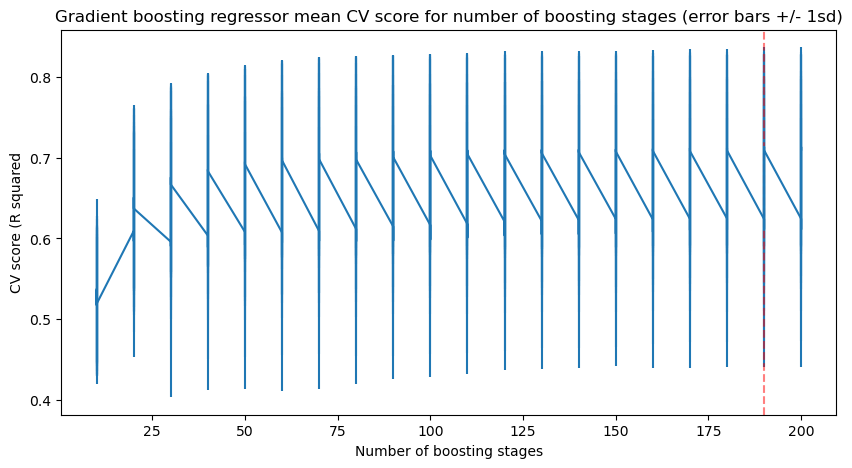

In [143]:
best_cv_n_est = gb_grid_cv.best_params_['gradientboostingregressor__n_estimators']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_n_est, score_mean, yerr = score_std)
plt.axvline(x = best_cv_n_est, c = 'r', ls = '--', alpha = 0.5)
plt.xlabel('Number of boosting stages')
plt.ylabel('CV score (R squared')
plt.title('Gradient boosting regressor mean CV score for number of boosting stages (error bars +/- 1sd)');

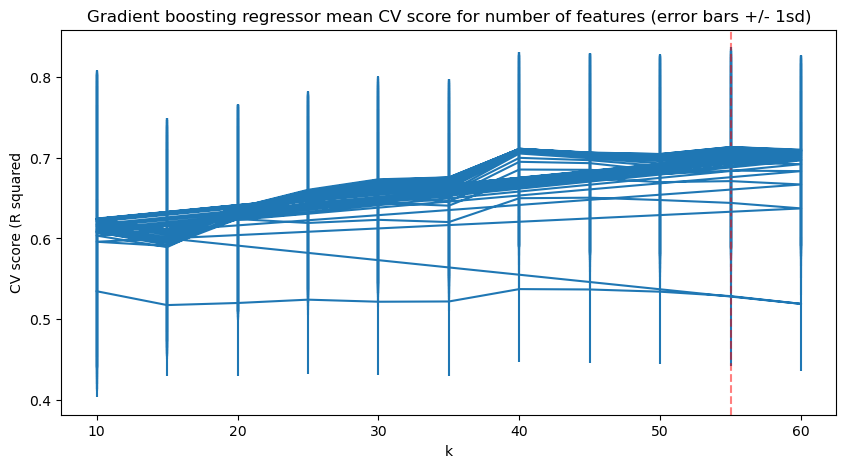

In [144]:
best_k = gb_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr = score_std)
plt.axvline(x = best_k, c = 'r', ls = '--', alpha = 0.5)
plt.xlabel('k')
plt.ylabel('CV score (R squared')
plt.title('Gradient boosting regressor mean CV score for number of features (error bars +/- 1sd)');

In [145]:
gb_model_best = make_pipeline(SelectKBest(f_regression, k = 55), GradientBoostingRegressor(n_estimators = 190, random_state = 123))
gb_model_best.fit(X_train_scaled, y_train)
y_train_pred = gb_model_best.predict(X_train_scaled)
y_test_pred = gb_model_best.predict(X_test_scaled)

model_evaluation(y_train, y_train_pred, y_test, y_test_pred, 'Gradient Boosting model (k=55, boosting stages=190) results:')

Gradient Boosting model (k=55, boosting stages=190) results:

Training R squared: 0.9475
Testing R squared: 0.6404

Training MAE: 4236.62
Testing MAE: 6439.04

Training MSE: 63764250.97
Testing MSE: 410288724.39


This model performed similarly to the random forest regression model. There is definitely evidence of overfitting here as well, but either of these two models would be much better than the dummy regressor, linear regression, ridge regression, or lasso regression.

Cross validation is performed to further understand the performance of the model.

In [148]:
cv_results = cross_validate(gb_model_best, X_train_scaled, y_train, cv = 5, n_jobs = -1)
print('CV results (R squared values):', cv_results['test_score'])
print(f'Mean R squared: {cv_results['test_score'].mean():.4f}')
print(f'Standard deviation R squared: {cv_results['test_score'].std():.4f}')

CV results (R squared values): [0.83855676 0.48414816 0.74368137 0.70176461 0.79643336]
Mean R squared: 0.7129
Standard deviation R squared: 0.1234


The top features are listed by importance.

In [150]:
selected = gb_grid_cv.best_estimator_.named_steps.selectkbest.get_support()
coefs = gb_grid_cv.best_estimator_.named_steps.gradientboostingregressor.feature_importances_
features = X_train.columns[selected]
pd.Series(coefs, index = features).sort_values(ascending = False)

num_encounters                                                              4.756610e-01
num_procedures                                                              9.672402e-02
Leukocytes [#/volume] in Blood by Automated count                           9.120169e-02
DALY                                                                        6.944309e-02
AGE                                                                         4.144996e-02
num_meds                                                                    3.772218e-02
Hematocrit [Volume Fraction] of Blood by Automated count                    2.745116e-02
Glomerular filtration rate/1.73 sq M.predicted [Volume Rate/Area]           2.671468e-02
Chloride [Moles/volume] in Blood                                            2.298161e-02
meds_cost                                                                   2.236827e-02
QALY                                                                        1.701235e-02
QOLS                 

The model r squared, MAE, and MSE scores are saved to compare to the dummy regressor model.

In [152]:
gb_train_r2 = r2_score(y_train, y_train_pred)
gb_test_r2 = r2_score(y_test, y_test_pred)
gb_train_mae = mean_absolute_error(y_train, y_train_pred)
gb_test_mae = mean_absolute_error(y_test, y_test_pred)
gb_train_mse = mean_squared_error(y_train, y_train_pred)
gb_test_mse = mean_squared_error(y_test, y_test_pred)

#### Model selection

Both the random forest model and the gradient boosting model performed much better than any of the other models tested. The difference between these two is so minimal and is likely due to how the data was split into training and testing sets. Since both models are similar, the random forest model will be selected for this dataset. This model is saved and exported.

In [155]:
best_model = rf_grid_cv.best_estimator_
best_model.version = 1.0
best_model.pandas_version = pd.__version__
best_model.numpy_version = np.__version__
best_model.sklearn_version = sklearn_version
best_model.X_columns = [col for col in X_train.columns]
best_model.build_datetime = datetime.datetime.now()

In [156]:
model_pkl_file = '../output/encounters_pricing_model.pkl'
pickle.dump(best_model, open(model_pkl_file, 'wb'))

The random forest model scores are compared to the dummy regressor model scores to show its improvement.

In [158]:
train_r2 = abs(100 * (rf_train_r2 - dummy_train_r2) / rf_train_r2)
test_r2 = abs(100 * (rf_test_r2 - dummy_test_r2) / rf_test_r2)
train_mae = abs(100 * (rf_train_mae - dummy_train_mae) / rf_train_mae)
test_mae = abs(100 * (rf_test_mae - dummy_test_mae) / rf_test_mae)
train_mse = abs(100 * (rf_train_mse - dummy_train_mse) / rf_train_mse)
test_mse = abs(100 * (rf_test_mse - dummy_test_mse) / rf_test_mse)

print('Percent change between dummy regressor and random forest regressor:')
print('')
print('Percent change training R squared:', round(train_r2, 4), '%')
print('Percent change testing R squared:', round(test_r2, 4), '%')
print('')
print('Percent change training MAE:', round(train_mae, 4), '%')
print('Percent change testing MAE:', round(test_mae, 4), '%')
print('')
print('Percent change training MSE:', round(train_mse, 4), '%')
print('Percent change testing MSE:', round(test_mse, 4), '%')

Percent change between dummy regressor and random forest regressor:

Percent change training R squared: 100.0 %
Percent change testing R squared: 100.1014 %

Percent change training MAE: 615.5654 %
Percent change testing MAE: 180.1011 %

Percent change training MSE: 1642.0494 %
Percent change testing MSE: 174.1303 %


There are dramatic improvements in all metrics comparing the dummy regressor model to the random forest model.

Now, the final model is used on the entire dataset.

In [161]:
X = df_knn.drop(columns = ['encounters_cost'])
y = df_knn['encounters_cost']

scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [162]:
best_model.fit(X_scaled, y)

Pipeline(steps=[('selectkbest',
                 SelectKBest(k=45,
                             score_func=<function f_regression at 0x000001E972AB1940>)),
                ('randomforestregressor',
                 RandomForestRegressor(n_estimators=80, random_state=123))])

In [163]:
y_pred = best_model.predict(X_scaled)
print('R squared:', round(r2_score(y, y_pred), 4))
print('MAE:', round(mean_absolute_error(y, y_pred), 2))
print('MSE:', round(mean_squared_error(y, y_pred),2))

R squared: 0.9495
MAE: 2379.54
MSE: 60360773.59


The R squared value is very close to 1, suggesting that this model is a good fit for the data. The MAE and MSE values are also quite low, with the MAE of 2,379.54 suggesting that on average, you could expect to estimate a patient's yearly medical encounters cost within about 2,500 dollars.

Finally, the top 20 features are listed in order of importance.

In [166]:
selected = best_model.named_steps.selectkbest.get_support()
coefs = best_model.named_steps.randomforestregressor.feature_importances_
features = X_train.columns[selected]
pd.Series(coefs, index = features).sort_values(ascending = False)[0:20]

num_encounters                                                       0.453449
num_procedures                                                       0.089096
DALY                                                                 0.079989
Glomerular filtration rate/1.73 sq M.predicted [Volume Rate/Area]    0.037724
Leukocytes [#/volume] in Blood by Automated count                    0.035729
Hematocrit [Volume Fraction] of Blood by Automated count             0.023208
Body mass index (BMI) [Ratio]                                        0.023044
Pain severity - 0-10 verbal numeric rating [Score] - Reported        0.022502
AGE                                                                  0.021957
meds_cost                                                            0.020679
Urea nitrogen [Mass/volume] in Blood                                 0.017856
Chloride [Moles/volume] in Blood                                     0.016939
Cholesterol in HDL [Mass/volume] in Serum or Plasma             

Unsurprisingly, the number of medical encounters and number of procedures are the top two features, as these are expected to be correlated with the cost of medical encounters. However, some other interesting factors include DALY (disability-adjusted life year, a metric used to measure overall disease burden of a population), BMI (body mass index), pain severity, age, and number/cost of medications. Some of these factors are out of a patient's control, such as age, but it would be beneficial to investigate which factors could be altered through lifestyle interventions to reduce a patient's medical encounters costs.

Finally, the requirements.txt file is created.

In [169]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.
